In [18]:
# Import packages

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io

auth = ('FDS_DEMO_EUR_464603_SERVICES', '6hc85SGcgWCrkbJo')

In [19]:
## Define the names of factors that you are interested and enter their corresponding screening formulas

qfl_data = pd.read_excel('QFL.xlsx', header = 1)

qfl_data = qfl_data.drop(['Unnamed: 0'], axis = 1)

qfl_data.head()

,Factor Group,Field ID,Field Name,FactSet Screening Formula,Data Source,Unnamed: 6,Currency,Shares,CACCESS,Search Keywords,Data Type,String Length
0,Asset Data,DAYS_SINCE_RPT,Days Since Report,QFL_DAYS_SINCE_RPT(0),FactSet Estimates,"'Days Since Report': 'QFL_DAYS_SINCE_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
1,Asset Data,DAYS_TO_RPT,Days to Report,QFL_DAYS_TO_RPT(0),FactSet Estimates,"'Days to Report': 'QFL_DAYS_TO_RPT(0)',",None,0,00QFL,"asset,data,estimates",INTEGER,NaN
2,Asset Data,ADR_FLAG,ADR Flag,QFL_ADR_FLAG(0),FactSet Reference Data,"'ADR Flag': 'QFL_ADR_FLAG(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
3,Asset Data,BANKRUPTCY,Bankruptcy Flag,QFL_BANKRUPTCY(0),FactSet Reference Data,"'Bankruptcy Flag': 'QFL_BANKRUPTCY(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN
4,Asset Data,PRIMARY_LIST,Primary Listing,QFL_PRIMARY_LIST(0),FactSet Reference Data,"'Primary Listing': 'QFL_PRIMARY_LIST(0)',",None,0,00QFL,"asset,reference,data",INTEGER,NaN


In [20]:
# create QFL factor categories dictionary: Key = Field Name, Values = FactSet Screening Formula

qfl_categories = qfl_data['Factor Group'].unique()
qfl_categories = list(np.delete(qfl_categories, [0,1,2]))

for i in qfl_categories:
    globals()['qfl_{0}'.format(i).lower()] = dict(qfl_data[qfl_data['Factor Group'] == i][['FactSet Screening Formula', 'FactSet Screening Formula']].values)

qfl_categories

['Size',
 'Value',
 'Growth',
 'Profitability',
 'Efficiency',
 'Solvency',
 'Management',
 'Quality',
 'Analyst Sentiment',
 'Crowding',
 'Insider Activity',
 'Corporate Governance',
 'Momentum',
 'Volatility',
 'Market Sensitivity',
 'Technical',
 'Liquidity']

In [21]:
qfl_factors = globals()['qfl_{0}'.format('Crowding').lower()] # change QFL Category here!

formulas = list(qfl_factors.values())
columns = list(qfl_factors.keys())

In [22]:
# Define Universe & QFL parameters

endpoint = "https://datadirect.factset.com/services/FastFetch?"
factlet = "ExtractBenchmarkDetail"

ids = "890100"
date = "11/30/2020"
fwd_date = "12/31/2020"

# Forward Returns, Size Class, Security Market Value (USD)

params = ['P_TOTAL_RETURN(' + str(date) + ',' + str(fwd_date) + ')',
          'QFL_SIZE_CLASS(' + str(date) + ')',
          'QFL_MKT_VAL_SEC(' + str(date) + ')']

items = 'PROPER_NAME, FG_GICS_SECTOR, PROPER(FG_COUNTRY)'

items_call = items + ',' + ','.join([str(elem) for elem in params]) + ',' + ','.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])

# cutoff = "10"
output_format = "pipe"
showTitle = "N"
showHeader = "N"
showDataType = "N"

response = requests.post(endpoint, auth=auth, data = {'factlet':factlet, 
                                                      'ids':ids, 
                                                      'items': items_call,
                                                      'dates':date, 
                                                      # 'cutoff':cutoff,
                                                      'format':output_format,
                                                      'showTitle':showTitle,
                                                      'showHeader':showHeader,
                                                      'showDataType':showDataType})

df = pd.read_csv(io.StringIO(response.text), sep = '|')

In [23]:
col_universe = ['BENCHMARK_ID', 'DATE', 'SECURITY_ID', 'Weight', 'proper_name',
       'fg_gics_sector', 'proper', 'p_total_return', 'qfl_size_class', 'qfl_mkt_val_sec']
items_call_pipe = '|'.join([str(qfl_elem) for qfl_elem in list(qfl_factors.values())])
columns_name = col_universe + items_call_pipe.split('|')
df.columns = pd.Index(columns_name)

In [24]:
qfl_df = df

In [25]:
qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_DTL(0,21D)","QFL_PASSIVE_DTL(0,63D)","QFL_PASSIVE_DTL(0,252D)","QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_SELLER_POSCHG(0,1M)","QFL_PASSIVE_SELLER_POSCHG(0,3M)","QFL_PASSIVE_SELLER_POSCHG(0,6M)","QFL_PASSIVE_SELLER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,1M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,3M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,6M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_DTL(0,21D)","QFL_ACTIVE_DTL(0,63D)","QFL_ACTIVE_DTL(0,252D)","QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_SELLER_POSCHG(0,1M)","QFL_ACTIVE_SELLER_POSCHG(0,3M)","QFL_ACTIVE_SELLER_POSCHG(0,6M)","QFL_ACTIVE_SELLER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,1M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,3M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,6M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_DTL(0,21D)","QFL_INSTIT_DTL(0,63D)","QFL_INSTIT_DTL(0,252D)","QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)","QFL_INSTIT_SELLER_POSCHG(0,1M)","QFL_INSTIT_SELLER_POSCHG(0,3M)","QFL_INSTIT_SELLER_POSCHG(0,6M)","QFL_INSTIT_SELLER_POSCHG(0,12M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,1M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,3M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,6M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,12M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,1M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,3M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,6M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_DTL(0,21D)","QFL_ETF_DTL(0,63D)","QFL_ETF_DTL(0,252D)","QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_B

In [26]:
qfl_df.tail()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_DTL(0,21D)","QFL_PASSIVE_DTL(0,63D)","QFL_PASSIVE_DTL(0,252D)","QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_SELLER_POSCHG(0,1M)","QFL_PASSIVE_SELLER_POSCHG(0,3M)","QFL_PASSIVE_SELLER_POSCHG(0,6M)","QFL_PASSIVE_SELLER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,1M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,3M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,6M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_DTL(0,21D)","QFL_ACTIVE_DTL(0,63D)","QFL_ACTIVE_DTL(0,252D)","QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_SELLER_POSCHG(0,1M)","QFL_ACTIVE_SELLER_POSCHG(0,3M)","QFL_ACTIVE_SELLER_POSCHG(0,6M)","QFL_ACTIVE_SELLER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,1M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,3M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,6M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_DTL(0,21D)","QFL_INSTIT_DTL(0,63D)","QFL_INSTIT_DTL(0,252D)","QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)","QFL_INSTIT_SELLER_POSCHG(0,1M)","QFL_INSTIT_SELLER_POSCHG(0,3M)","QFL_INSTIT_SELLER_POSCHG(0,6M)","QFL_INSTIT_SELLER_POSCHG(0,12M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,1M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,3M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,6M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,12M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,1M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,3M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,6M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_DTL(0,21D)","QFL_ETF_DTL(0,63D)","QFL_ETF_DTL(0,252D)","QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_B

In [47]:
# Summary Stats

qfl_df.describe()

,BENCHMARK_ID,Weight,p_total_return,qfl_mkt_val_sec,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_DTL(0,21D)","QFL_PASSIVE_DTL(0,63D)","QFL_PASSIVE_DTL(0,252D)","QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_SELLER_POSCHG(0,1M)","QFL_PASSIVE_SELLER_POSCHG(0,3M)","QFL_PASSIVE_SELLER_POSCHG(0,6M)","QFL_PASSIVE_SELLER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,1M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,3M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,6M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_DTL(0,21D)","QFL_ACTIVE_DTL(0,63D)","QFL_ACTIVE_DTL(0,252D)","QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_SELLER_POSCHG(0,1M)","QFL_ACTIVE_SELLER_POSCHG(0,3M)","QFL_ACTIVE_SELLER_POSCHG(0,6M)","QFL_ACTIVE_SELLER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,1M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,3M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,6M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_DTL(0,21D)","QFL_INSTIT_DTL(0,63D)","QFL_INSTIT_DTL(0,252D)","QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)","QFL_INSTIT_SELLER_POSCHG(0,1M)","QFL_INSTIT_SELLER_POSCHG(0,3M)","QFL_INSTIT_SELLER_POSCHG(0,6M)","QFL_INSTIT_SELLER_POSCHG(0,12M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,1M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,3M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,6M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,12M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,1M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,3M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,6M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_DTL(0,21D)","QFL_ETF_DTL(0,63D)","QFL_ETF_DTL(0,252D)","QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_BUYER_POSCHG(0,1M)","QFL_ETF_BUYER_POSCHG(0,3M)","QFL_ETF_BUYER_POS

In [58]:
qfl_df['QFL_INSTIT_BUYER_PCTPOSCHG(0,3M)'].sum()

0.0

In [28]:
# Check NAs

qfl_df.isna().sum()

BENCHMARK_ID                         0
DATE                                 0
SECURITY_ID                          0
Weight                               0
proper_name                          0
                                  ... 
QFL_HF_BUYER_PCTPOSCHG(0,12M)     1599
QFL_HF_SELLER_PCTPOSCHG(0,1M)     1599
QFL_HF_SELLER_PCTPOSCHG(0,3M)     1599
QFL_HF_SELLER_PCTPOSCHG(0,6M)     1599
QFL_HF_SELLER_PCTPOSCHG(0,12M)    1599
Length: 210, dtype: int64

In [59]:
# Filter for float/numeric parameters only

filter_idx = [idx for idx, col in enumerate(qfl_df.columns) if idx > 9 and qfl_df[col].count() > 0 and qfl_df[col].sum() > 0 and qfl_df[col].values.dtype == 'float64']

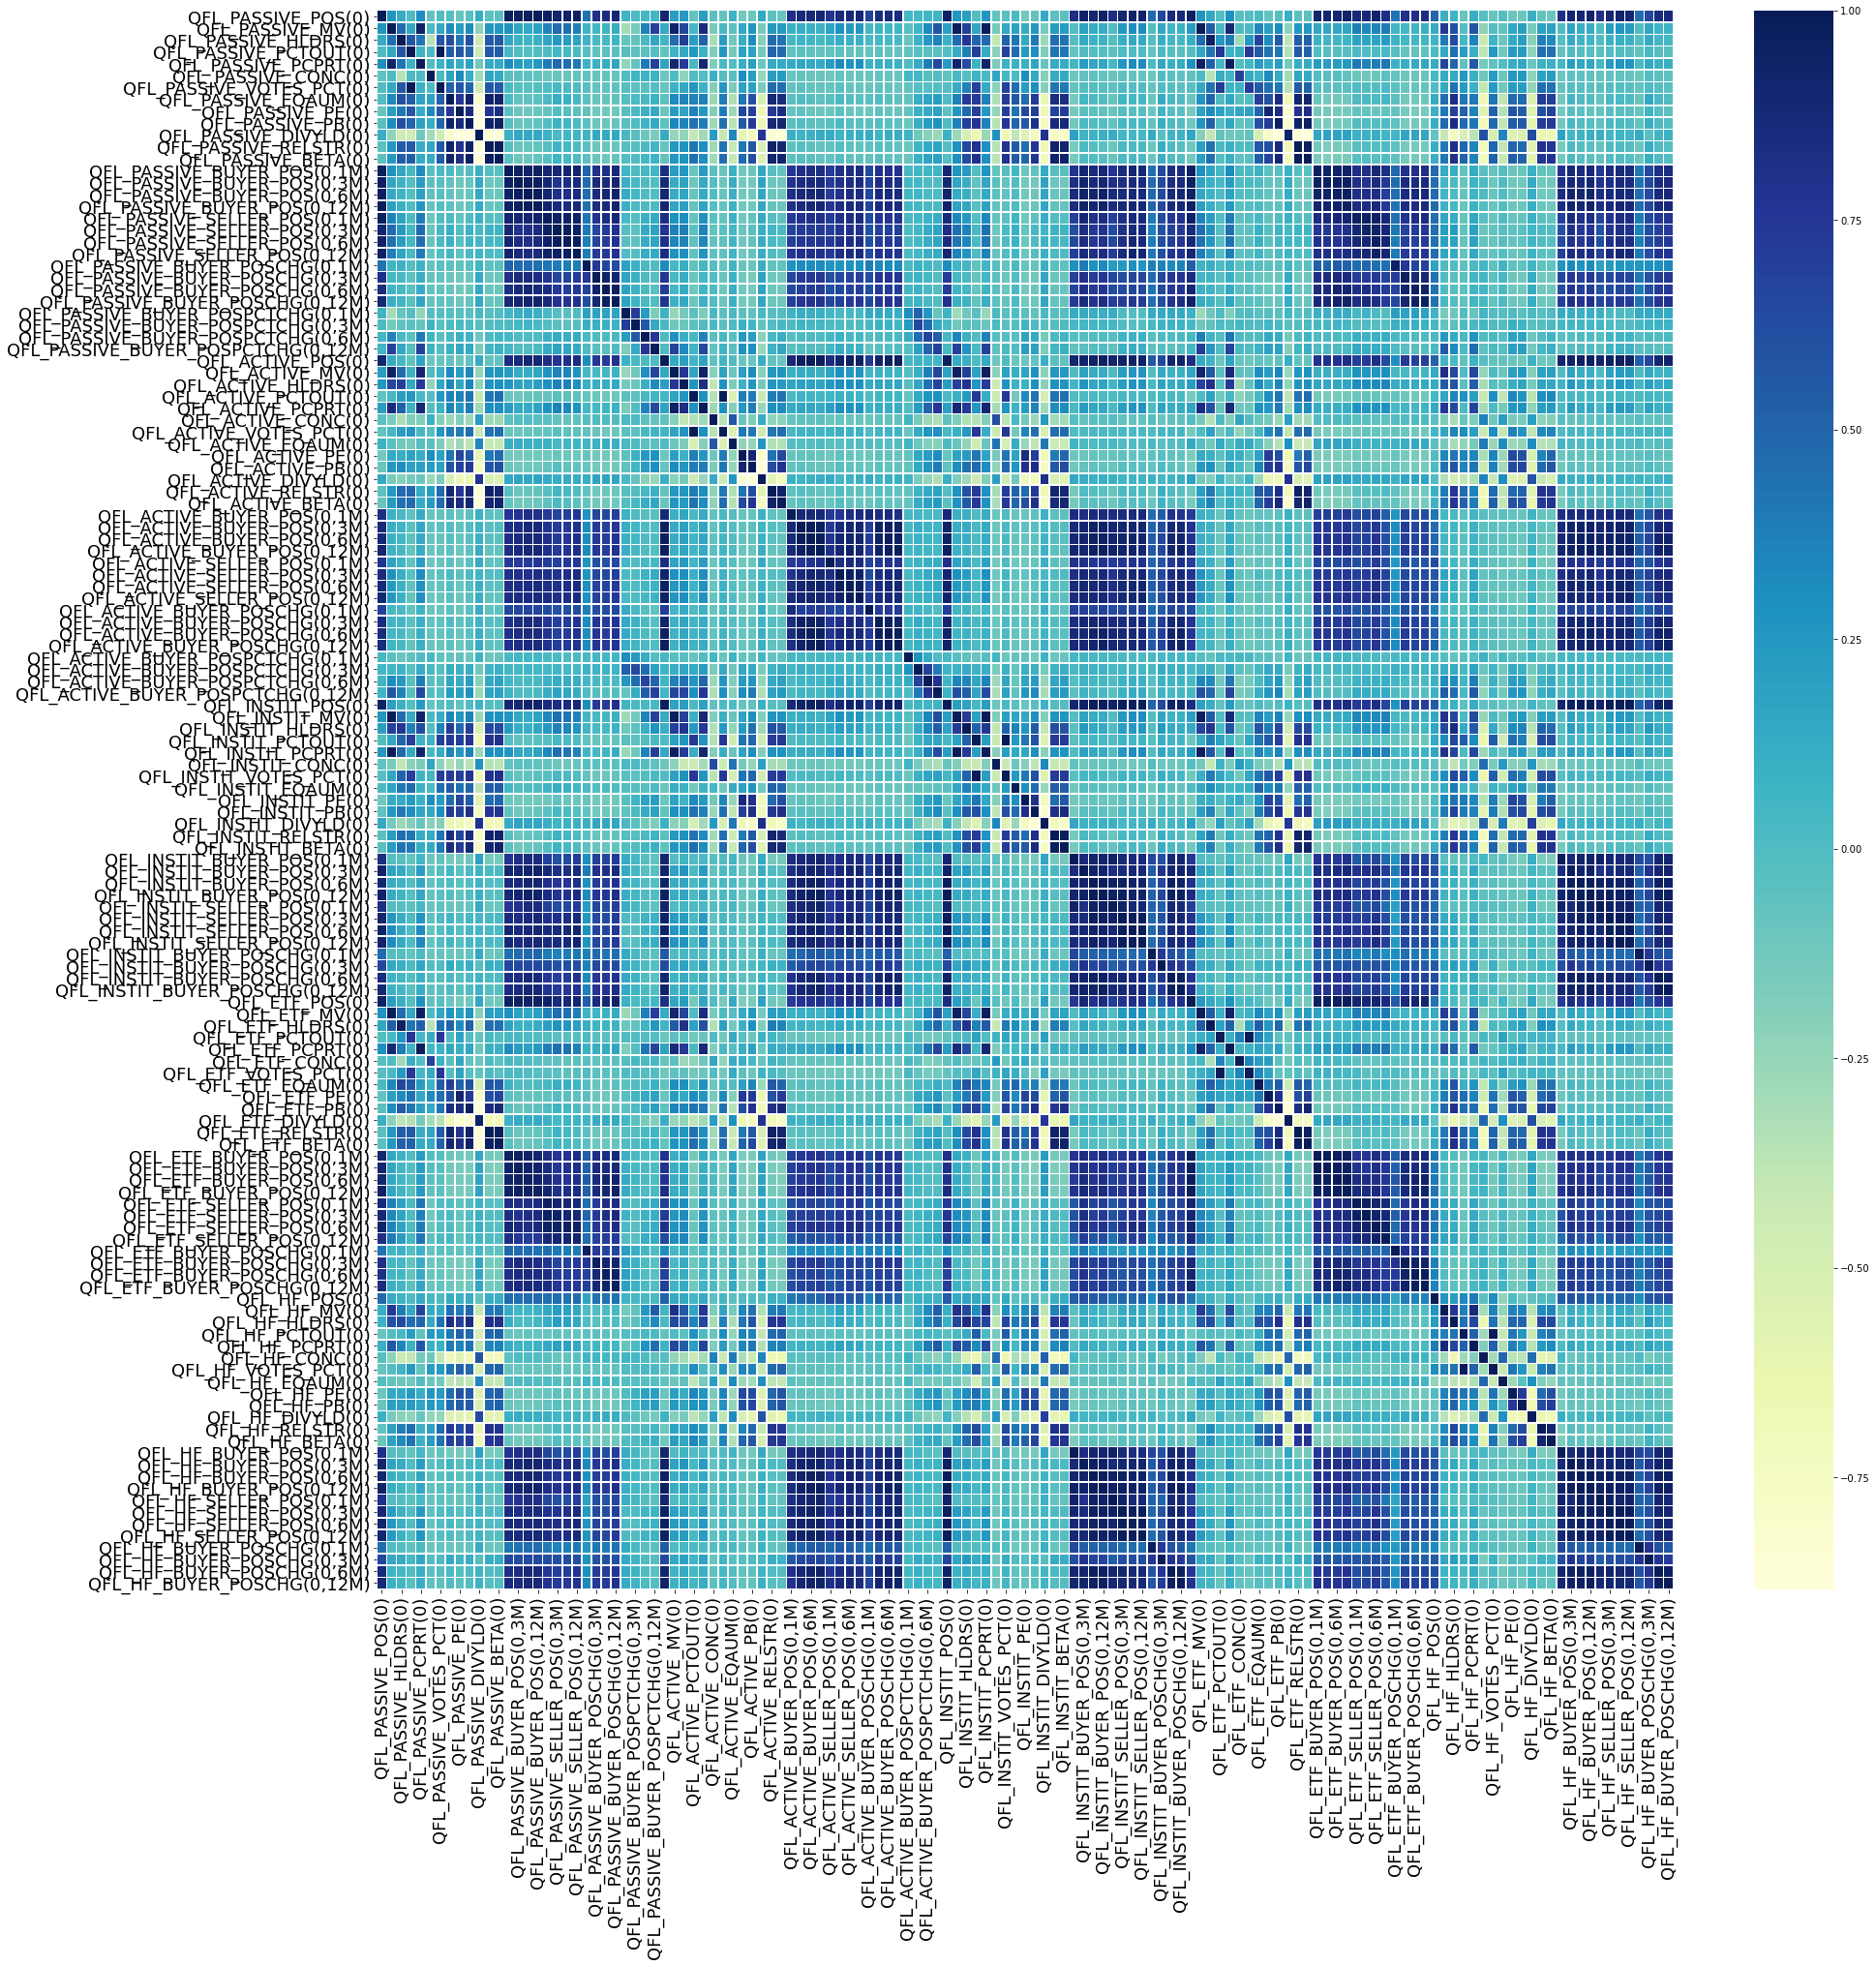

In [60]:
## Plot the correlation between each pair of factors

fig, ax = plt.subplots(figsize=(30,30))
hm = sns.heatmap(qfl_df[[c for c in qfl_df.columns[filter_idx]]].corr(), cmap="YlGnBu", annot = False, linewidths=.5, ax = ax)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 18, rotation=0)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 18, rotation=90)
plt.show()

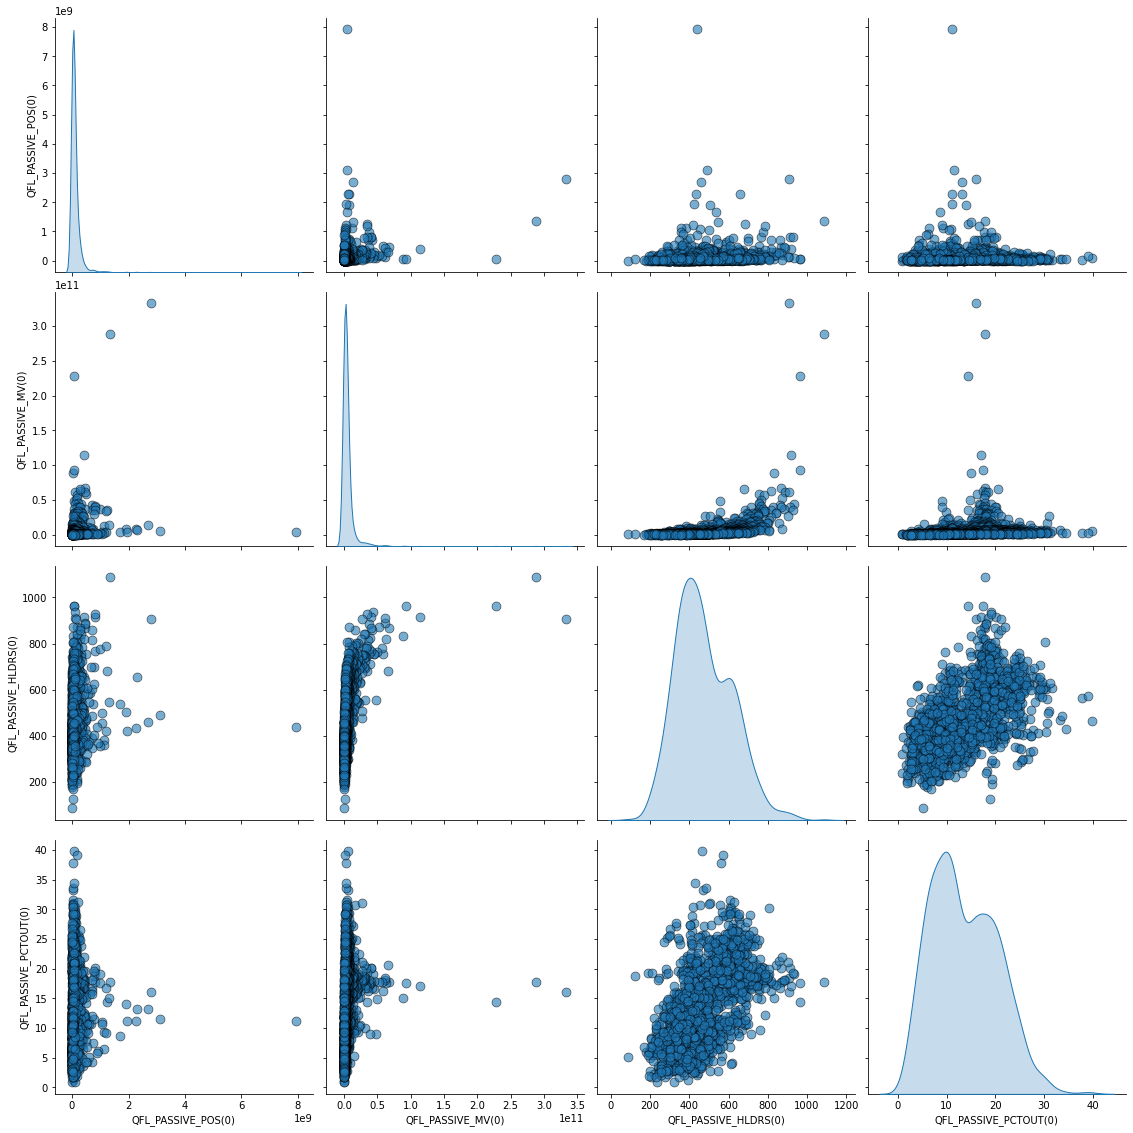

In [61]:
# Pairplot

sns.pairplot(qfl_df[qfl_df.columns[filter_idx[:4]].values], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 4);
#plt.show()

In [63]:
qfl_df[qfl_df.columns[filter_idx[:4]].values]

,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0)
0,2.794752e+09,3.327152e+11,907.0,16.12
1,1.345960e+09,2.881296e+11,1088.0,17.80
2,7.193483e+07,2.278924e+11,963.0,14.36
3,4.121365e+08,1.141494e+11,917.0,17.14
4,5.018489e+07,8.836255e+10,834.0,15.04
...,...,...,...,...
1595,1.692796e+07,3.146806e+08,221.0,11.71
1596,9.925482e+07,2.179751e+08,328.0,8.42
1597,2.307321e+07,2.772204e+08,230.0,10.57
1598,9.659225e+07,1.741486e+08,357.0,6.48


In [64]:
# Other Statistics

advanced_describe = {}
stats_table = pd.DataFrame()
for factor in list(qfl_df.columns[filter_idx].values):
    advanced_describe[factor] = stats.describe(qfl_df[factor].dropna(), axis=0)    
    adv_stats = {keys: [np.round(series, 2) for series in values] for (keys, values) in zip(advanced_describe.keys(), advanced_describe.values())}
    stats_table = pd.DataFrame(adv_stats, index=['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']).T
stats_table

,nobs,minmax,mean,variance,skewness,kurtosis
QFL_PASSIVE_POS(0),1598,"[14867.0, 7921449831.0]",1.11177e+08,8.61164e+16,14.75,333.82
QFL_PASSIVE_MV(0),1598,"[140712770.0, 332715200000.0]",5.02641e+09,2.20021e+20,14.23,266.09
QFL_PASSIVE_HLDRS(0),1598,"[85.0, 1088.0]",473.7,20437.4,0.52,0.03
QFL_PASSIVE_PCTOUT(0),1598,"[0.83, 39.84]",13.67,45.46,0.42,-0.42
QFL_PASSIVE_PCPRT(0),1598,"[0.01, 6.37]",0.16,0.1,10.68,169.69
...,...,...,...,...,...,...
"QFL_HF_SELLER_POS(0,12M)",1591,"[6821.0, 17394805405.0]",1.22261e+08,2.73806e+17,24.28,755.96
"QFL_HF_BUYER_POSCHG(0,1M)",1597,"[19.0, 929963730.0]",3.75085e+06,8.76769e+14,22.35,629.44
"QFL_HF_BUYER_POSCHG(0,3M)",1598,"[235.0, 945810766.0]",1.88871e+07,1.85257e+15,10.72,179.16
"QFL_HF_BUYER_POSCHG(0,6M)",1598,"[29647.0, 4428084463.0]",4.41661e+07,2.04932e+16,20.31,567.13


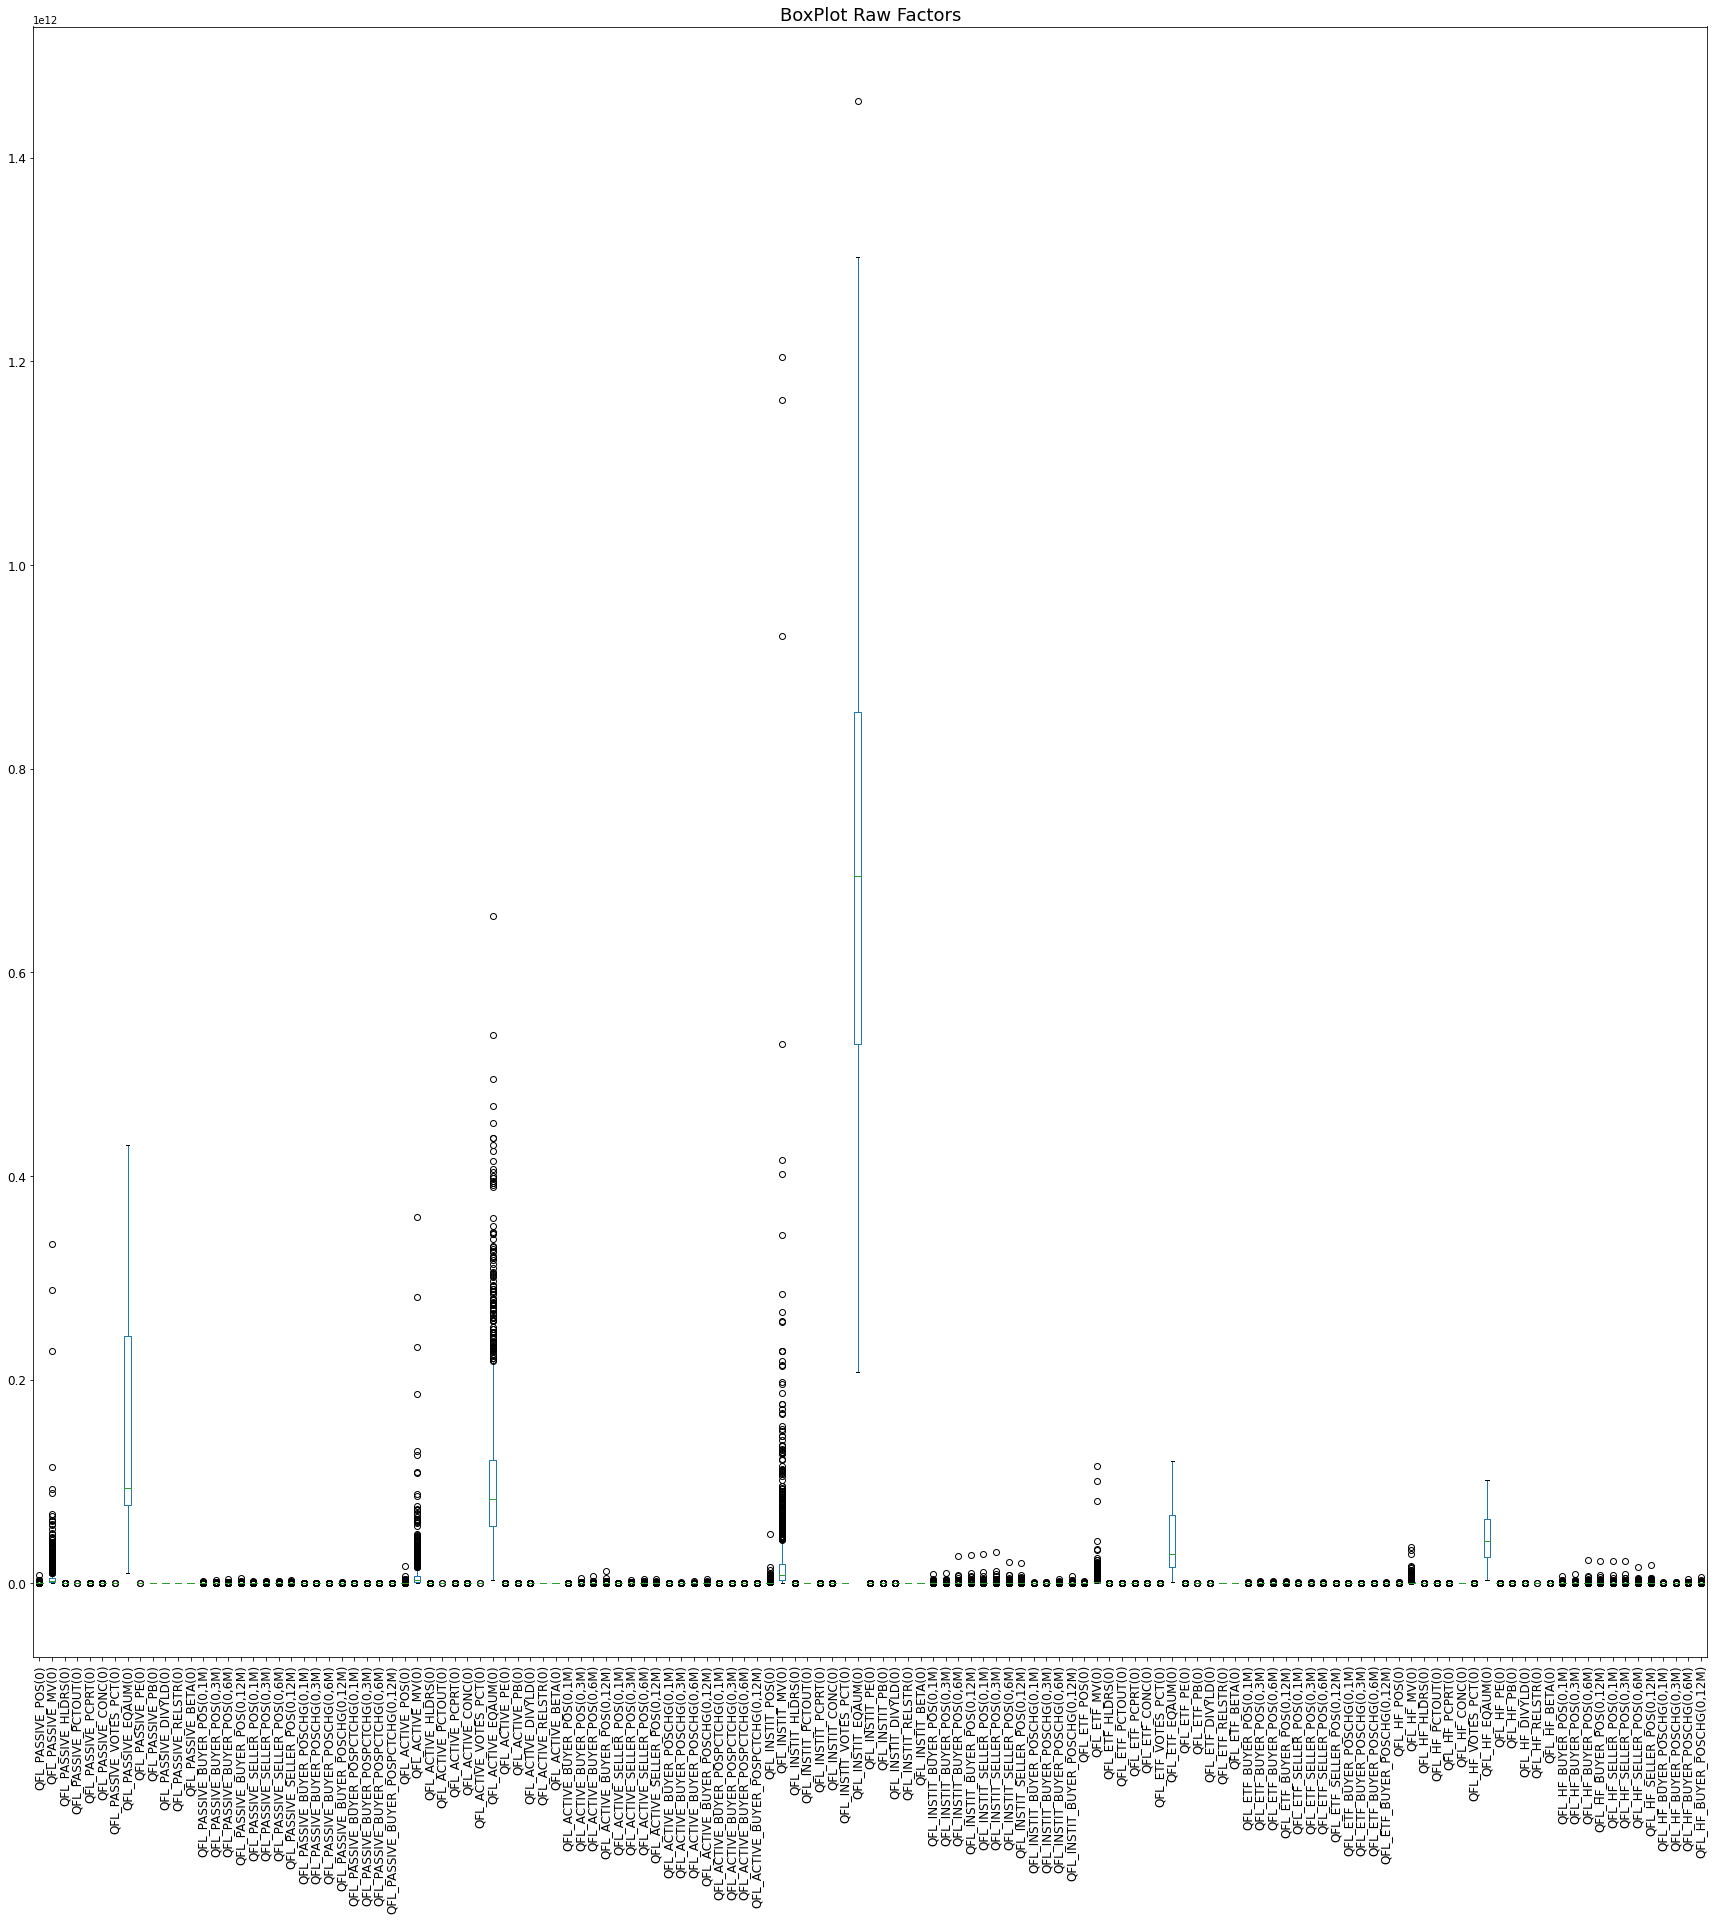

In [65]:
# Box-Whisker plot

qfl_df[qfl_df.columns[filter_idx]].boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Raw Factors', fontsize = 18);

In [66]:
# Z-Score

qfl_df_z = pd.DataFrame()

for factor in qfl_df[qfl_df.columns[filter_idx]]:
    z_score = ( qfl_df[factor] - qfl_df[factor].mean() ) / qfl_df[factor].std()
    qfl_df_z[factor] = z_score

qfl_df_z.describe()

,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_BUYER_POSCHG(0,1M)","QFL_ETF_BUYER_POSCHG(0,3M)","QFL_ETF_BUYER_POSCHG(0,6M)","QFL_ETF_BUYER_POSCHG(0,12M)",QFL_HF_POS(0),QFL_HF_MV(0),QFL_HF_HLDRS(0),QFL_HF_PCTOUT(0),QFL_HF_PCPRT(0),QFL_HF_CONC(0),QFL_HF_VOTES_PCT(0),QFL_HF_EQAUM(0),QFL_HF_PE(0),QFL_HF_PB(0),QFL_HF_DIVYLD(0),QFL_HF_RELSTR(0),QFL_HF_BETA(0),"QFL_HF_BUYER_POS(0,1M)","QFL_HF_BUYER_POS(0,3M)","QFL_HF_BUYER_POS(0,6M)","QFL_HF_BUYER_POS(0,12M)","QFL_HF_SELLER_POS(0,1M)","QFL_HF_SELLER_POS(0,3M)","QFL_HF_SELLER_POS(0,6M)","QFL_HF_SELLER_POS(0,12M)","QFL_HF_BUYER_POSCHG(0,1M)","QFL_HF_BUYER_POSCHG(0,3M)","QFL_HF_BUYER_POSCHG(0,6M)","QFL_HF_BUYER_POSCHG(0,12M)"
count,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.505000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.596000e+03,1.594000e+03,1.591000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.505000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.589000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.596000e+03,1.596000e+03,1.594000e+03,1.591000e+03,1.589000e+03,1.598000e+03,1.598000e+03,1.598000e+03,1.589000e+03,1.598000e+03,1.598000e+03,1.598000e+0

In [68]:
# look for "extremely large" column's values after normalization (Descending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = False)
    
qfl_df_z

,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_BUYER_POSCHG(0,1M)","QFL_ETF_BUYER_POSCHG(0,3M)","QFL_ETF_BUYER_POSCHG(0,6M)","QFL_ETF_BUYER_POSCHG(0,12M)",QFL_HF_POS(0),QFL_HF_MV(0),QFL_HF_HLDRS(0),QFL_HF_PCTOUT(0),QFL_HF_PCPRT(0),QFL_HF_CONC(0),QFL_HF_VOTES_PCT(0),QFL_HF_EQAUM(0),QFL_HF_PE(0),QFL_HF_PB(0),QFL_HF_DIVYLD(0),QFL_HF_RELSTR(0),QFL_HF_BETA(0),"QFL_HF_BUYER_POS(0,1M)","QFL_HF_BUYER_POS(0,3M)","QFL_HF_BUYER_POS(0,6M)","QFL_HF_BUYER_POS(0,12M)","QFL_HF_SELLER_POS(0,1M)","QFL_HF_SELLER_POS(0,3M)","QFL_HF_SELLER_POS(0,6M)","QFL_HF_SELLER_POS(0,12M)","QFL_HF_BUYER_POSCHG(0,1M)","QFL_HF_BUYER_POSCHG(0,3M)","QFL_HF_BUYER_POSCHG(0,6M)","QFL_HF_BUYER_POSCHG(0,12M)"
0,26.614807,22.091713,4.297025,3.881723,19.678526,7.501372,3.846330,3.094715,3.087904,2.465932,2.881917,1.380292,1.678989,24.494614,26.107320,28.372641,26.779344,21.104505,18.719044,19.145142,23.395069,24.776697,20.868366,18.630146,20.982781,7.781640,21.254287,20.374395,20.995031,30.120565,20.275923,9.196573,3.663629,14.033120,10.189664,3.614146,7.664472,7.008257,4.107511,3.292730,1.656185,2.857049,29.906816,32.774772,31.729742,31.231635,19.101950,24.428648,25.141235,25.401108,18.959401,29.346986,29.778701,29.306346,30.535619,7.038956,8.151962,10.407236,31.933015,19.817037,7.014290,2.614142,19.202754,10.686790,2.576939,3.581219,6.488829,3.779382,4.141209,1.507420,3.285630,29.572272,25.682422,33.613446,32.347211,34.769468,32.752595,30.632707,30.6451

In [69]:
# look for "extremely large" column's values after normalization (Ascending)

for col_z in qfl_df_z:
    qfl_df_z[col_z] = qfl_df_z[col_z].sort_values(ignore_index=True, ascending = True)
    
qfl_df_z

,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_BUYER_POSCHG(0,1M)","QFL_ETF_BUYER_POSCHG(0,3M)","QFL_ETF_BUYER_POSCHG(0,6M)","QFL_ETF_BUYER_POSCHG(0,12M)",QFL_HF_POS(0),QFL_HF_MV(0),QFL_HF_HLDRS(0),QFL_HF_PCTOUT(0),QFL_HF_PCPRT(0),QFL_HF_CONC(0),QFL_HF_VOTES_PCT(0),QFL_HF_EQAUM(0),QFL_HF_PE(0),QFL_HF_PB(0),QFL_HF_DIVYLD(0),QFL_HF_RELSTR(0),QFL_HF_BETA(0),"QFL_HF_BUYER_POS(0,1M)","QFL_HF_BUYER_POS(0,3M)","QFL_HF_BUYER_POS(0,6M)","QFL_HF_BUYER_POS(0,12M)","QFL_HF_SELLER_POS(0,1M)","QFL_HF_SELLER_POS(0,3M)","QFL_HF_SELLER_POS(0,6M)","QFL_HF_SELLER_POS(0,12M)","QFL_HF_BUYER_POSCHG(0,1M)","QFL_HF_BUYER_POSCHG(0,3M)","QFL_HF_BUYER_POSCHG(0,6M)","QFL_HF_BUYER_POSCHG(0,12M)"
0,-0.378804,-0.329378,-2.718950,-1.904179,-0.485202,-1.757133,-1.956433,-1.503008,-2.118642,-1.773981,-2.215528,-1.367203,-1.412119,-0.410121,-0.382727,-0.353408,-0.375247,-0.422957,-0.399366,-0.402277,-0.364613,-0.230155,-0.379871,-0.454594,-0.420897,-11.548381,-9.518736,-7.106747,-3.805427,-0.307572,-0.414844,-1.188797,-1.814991,-0.757112,-0.858799,-1.789096,-1.365753,-1.725352,-2.148753,-2.643105,-2.224501,-2.216396,-0.246710,-0.262670,-0.286206,-0.280722,-0.342337,-0.329731,-0.342363,-0.352430,-0.302433,-0.314217,-0.326409,-0.328836,-1.471607,-5.578745,-1.823318,-1.697455,-0.291602,-0.343819,-0.892123,-1.800849,-0.430151,-1.395526,-1.818801,-2.284066,-4.120363,-3.108642,-2.928390,-2.752215,-2.474688,-0.182774,-0.420076,-0.259709,-0.295558,-0.11

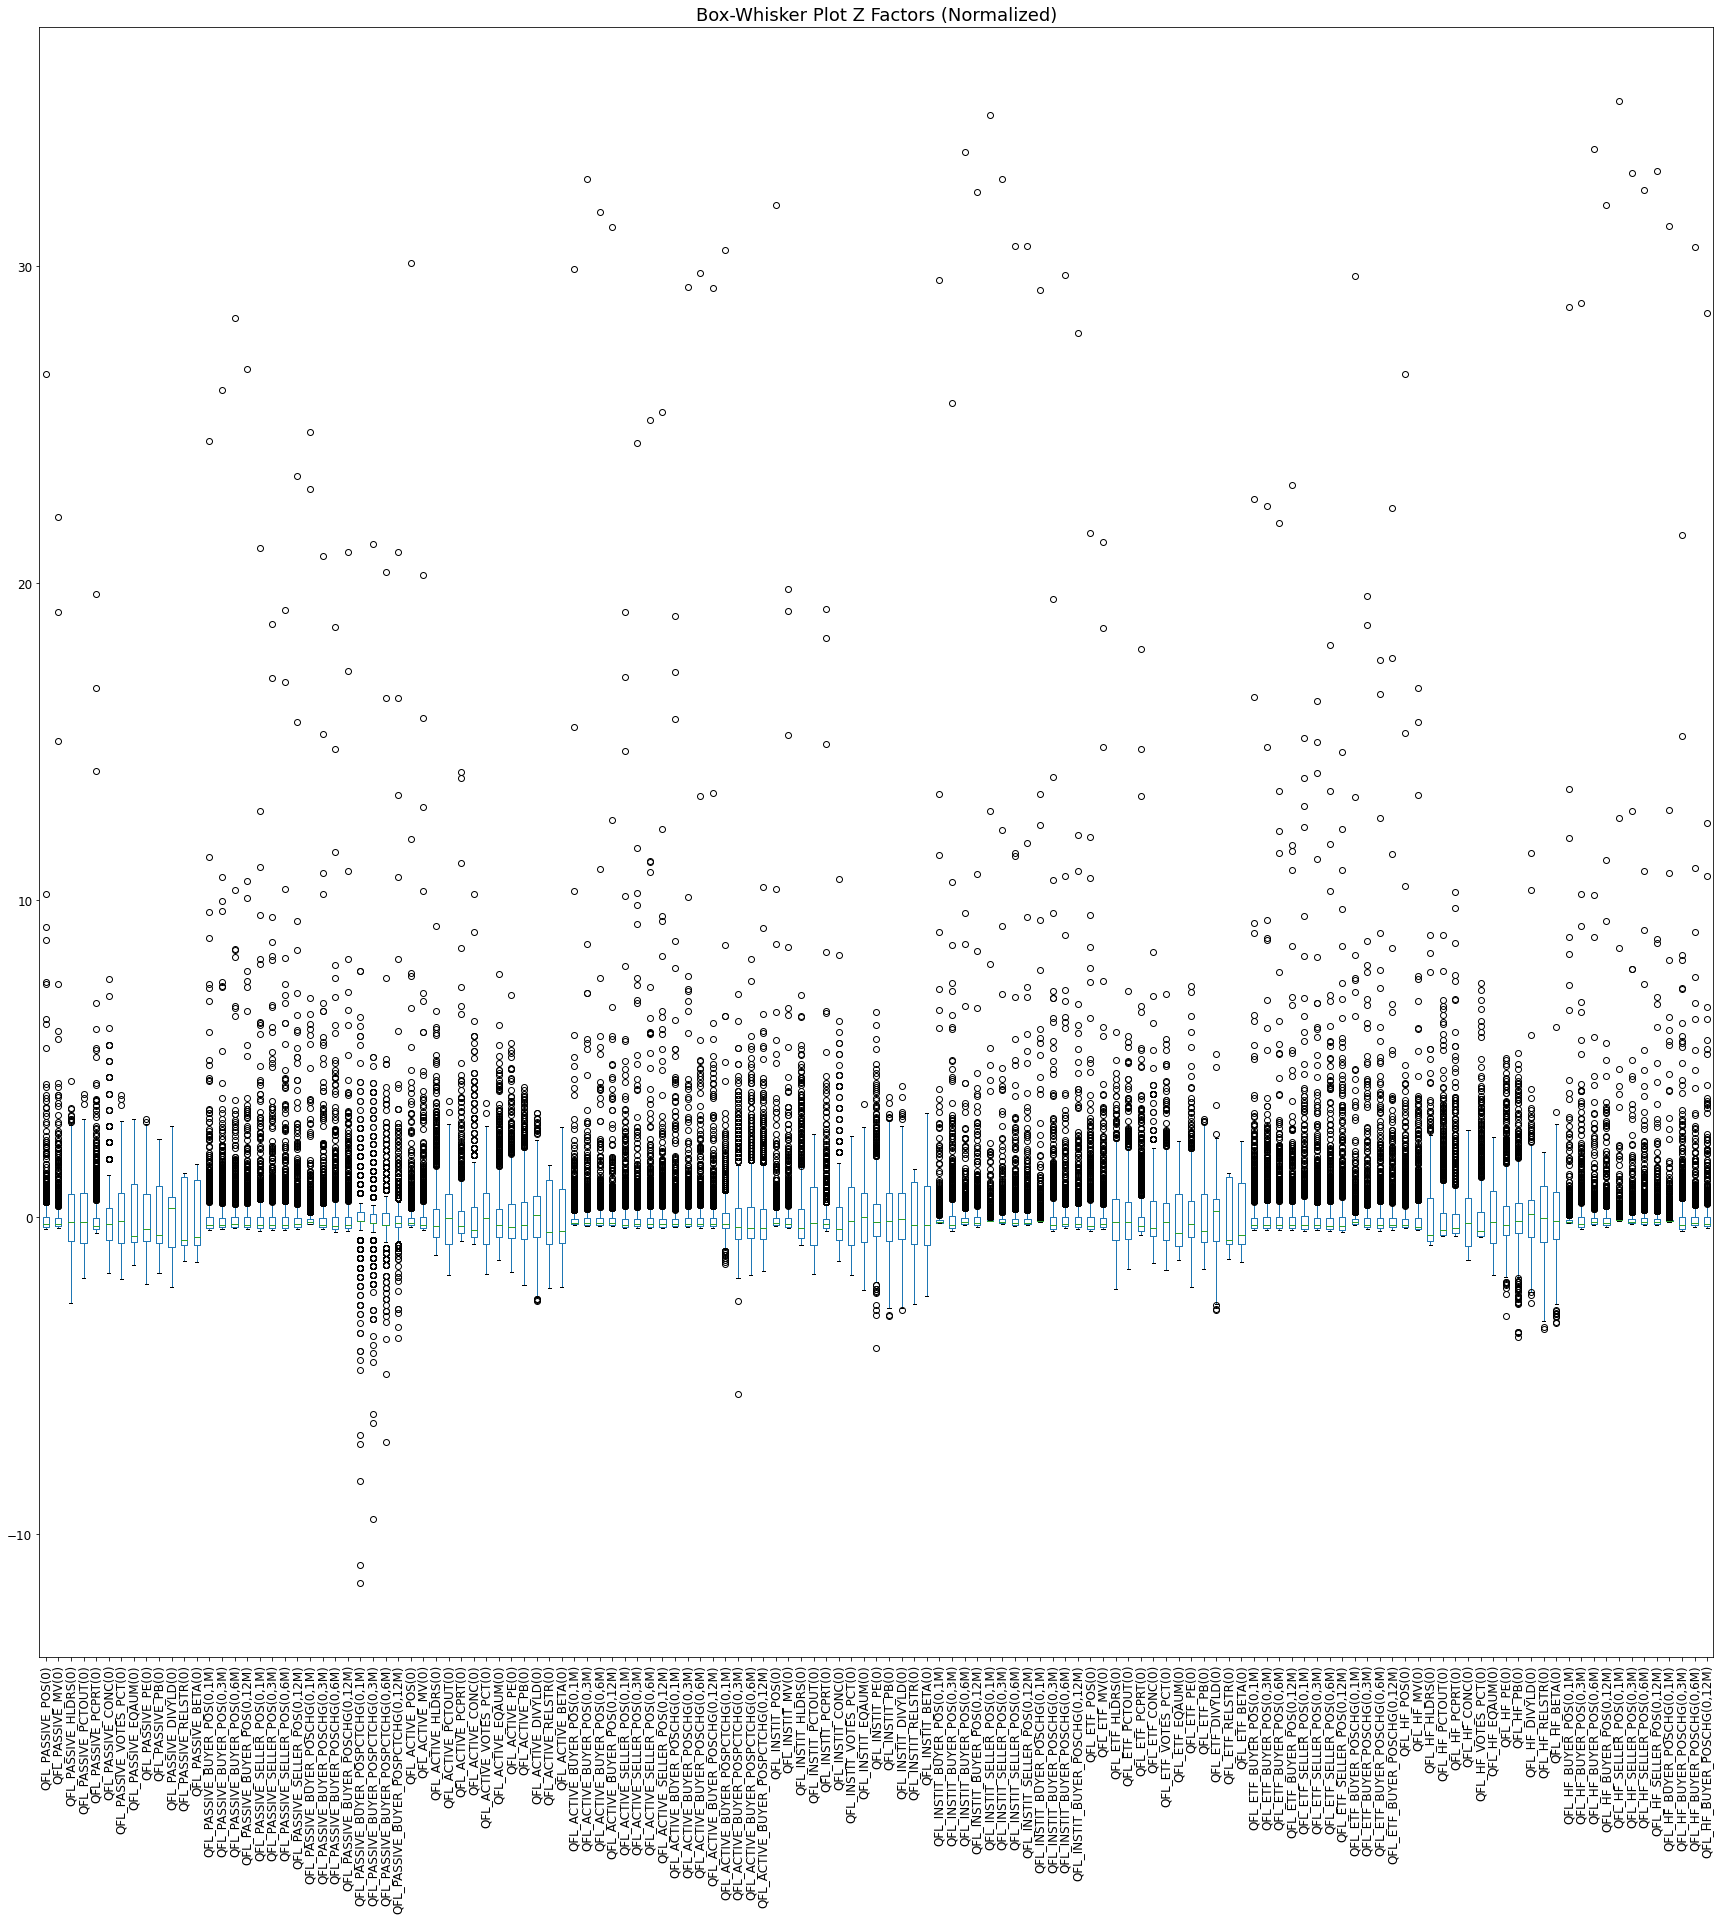

In [70]:
# Box-Whisker plot (Normalized data)

qfl_df_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot Z Factors (Normalized)', fontsize = 18);

In [72]:
# Greedy Multi-Factor Simple Average from all Multi-Factor's components

# MFR Z-Score

qfl_df_z['MFR'] = qfl_df_z.mean(axis = 1)

qfl_df_z.head()

,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_BUYER_POSCHG(0,1M)","QFL_ETF_BUYER_POSCHG(0,3M)","QFL_ETF_BUYER_POSCHG(0,6M)","QFL_ETF_BUYER_POSCHG(0,12M)",QFL_HF_POS(0),QFL_HF_MV(0),QFL_HF_HLDRS(0),QFL_HF_PCTOUT(0),QFL_HF_PCPRT(0),QFL_HF_CONC(0),QFL_HF_VOTES_PCT(0),QFL_HF_EQAUM(0),QFL_HF_PE(0),QFL_HF_PB(0),QFL_HF_DIVYLD(0),QFL_HF_RELSTR(0),QFL_HF_BETA(0),"QFL_HF_BUYER_POS(0,1M)","QFL_HF_BUYER_POS(0,3M)","QFL_HF_BUYER_POS(0,6M)","QFL_HF_BUYER_POS(0,12M)","QFL_HF_SELLER_POS(0,1M)","QFL_HF_SELLER_POS(0,3M)","QFL_HF_SELLER_POS(0,6M)","QFL_HF_SELLER_POS(0,12M)","QFL_HF_BUYER_POSCHG(0,1M)","QFL_HF_BUYER_POSCHG(0,3M)","QFL_HF_BUYER_POSCHG(0,6M)","QFL_HF_BUYER_POSCHG(0,12M)",MFR
0,-0.378804,-0.329378,-2.718950,-1.904179,-0.485202,-1.757133,-1.956433,-1.503008,-2.118642,-1.773981,-2.215528,-1.367203,-1.412119,-0.410121,-0.382727,-0.353408,-0.375247,-0.422957,-0.399366,-0.402277,-0.364613,-0.230155,-0.379871,-0.454594,-0.420897,-11.548381,-9.518736,-7.106747,-3.805427,-0.307572,-0.414844,-1.188797,-1.814991,-0.757112,-0.858799,-1.789096,-1.365753,-1.725352,-2.148753,-2.643105,-2.224501,-2.216396,-0.246710,-0.262670,-0.286206,-0.280722,-0.342337,-0.329731,-0.342363,-0.352430,-0.302433,-0.314217,-0.326409,-0.328836,-1.471607,-5.578745,-1.823318,-1.697455,-0.291602,-0.343819,-0.892123,-1.800849,-0.430151,-1.395526,-1.818801,-2.284066,-4.120363,-3.108642,-2.928390,-2.752215,-2.474688,-0.182774,-0.420076,-0.259709,-0.295558,-

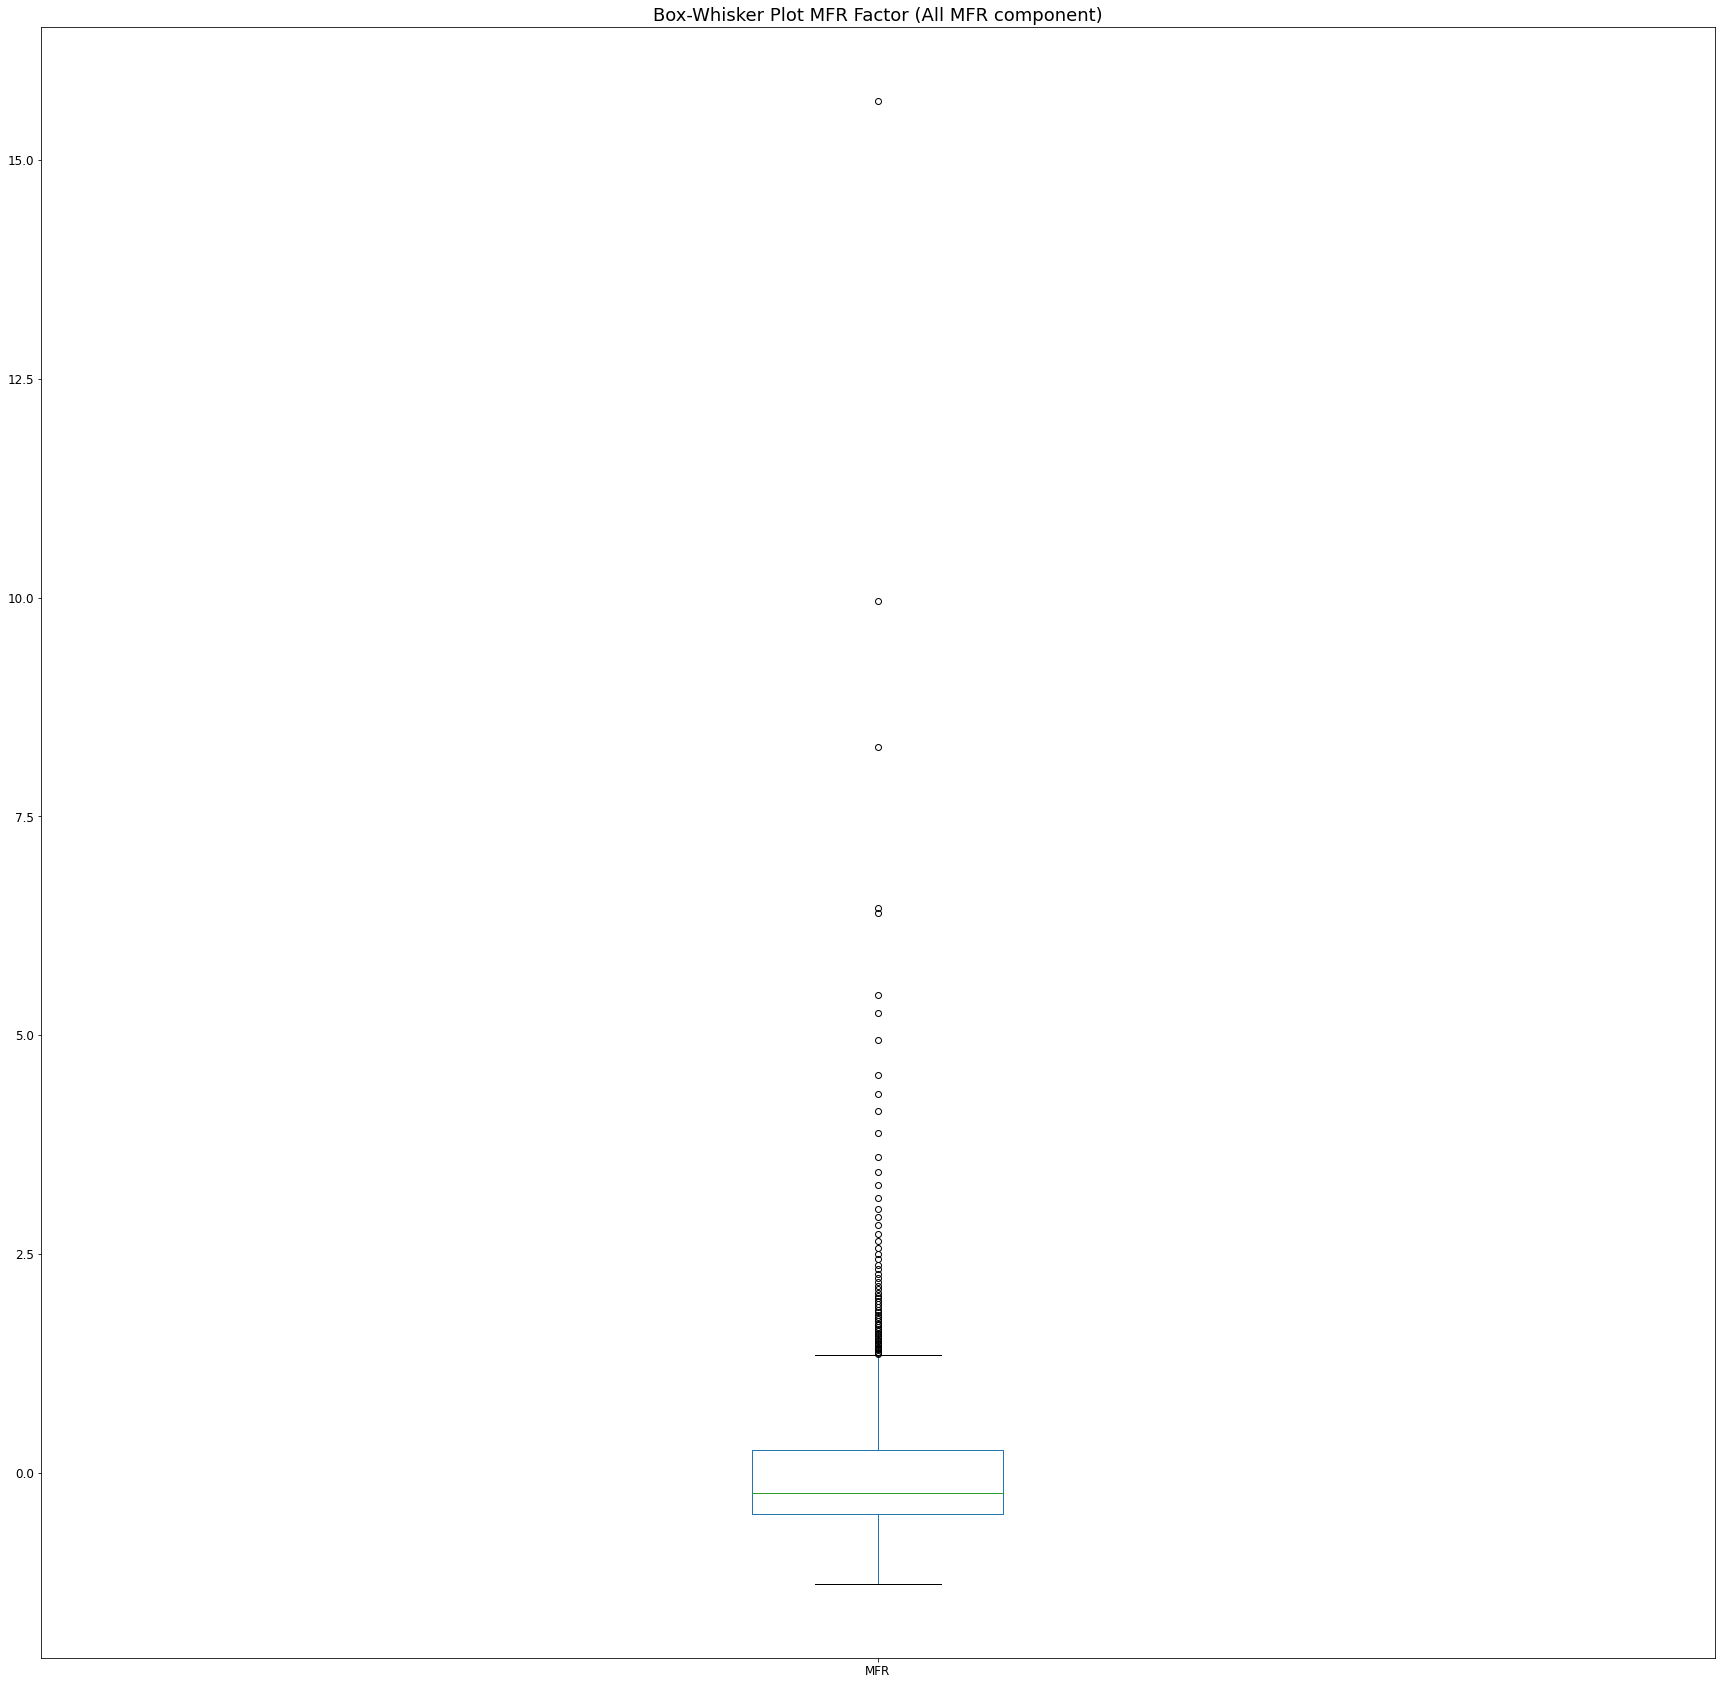

In [73]:
pd.DataFrame(qfl_df_z['MFR']).boxplot(grid=False, fontsize=12, figsize = (30,30)).set_title('Box-Whisker Plot MFR Factor (All MFR component)', fontsize = 18);

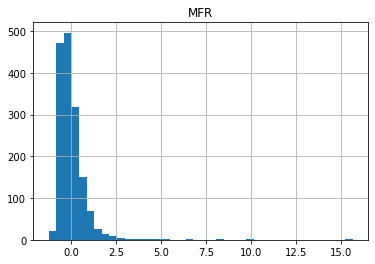

In [74]:
# MFR Distribution

pd.DataFrame(qfl_df_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [75]:
# Check Infomation Coefficient: MFR (Components: All, Z-Scored Only)

sp_corr_z, sp_pval_z = stats.spearmanr(-qfl_df_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04


C:\Users\ffais\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


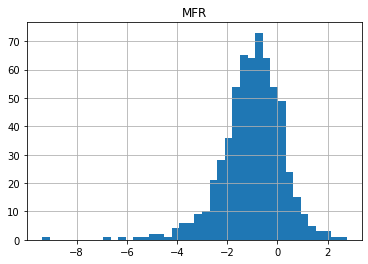

In [76]:
# MFR Log-Distribution

pd.DataFrame(np.log(qfl_df_z['MFR'])).hist(bins = int(np.sqrt(len(qfl_df_z['MFR']))));

In [77]:
# Log-Transformation for positive/not-zero features

qfl_df_log = pd.DataFrame()

for col_pos in qfl_df[qfl_df.columns[filter_idx]]:
    if np.sum(qfl_df[qfl_df.columns[filter_idx]][col_pos] <= 0) == 0:
        qfl_df_log[col_pos] = np.log(qfl_df[qfl_df.columns[filter_idx]][col_pos])
    else:
        qfl_df_log[col_pos] = qfl_df[qfl_df.columns[filter_idx]][col_pos]
    
qfl_df_log

,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_BUYER_POSCHG(0,1M)","QFL_ETF_BUYER_POSCHG(0,3M)","QFL_ETF_BUYER_POSCHG(0,6M)","QFL_ETF_BUYER_POSCHG(0,12M)",QFL_HF_POS(0),QFL_HF_MV(0),QFL_HF_HLDRS(0),QFL_HF_PCTOUT(0),QFL_HF_PCPRT(0),QFL_HF_CONC(0),QFL_HF_VOTES_PCT(0),QFL_HF_EQAUM(0),QFL_HF_PE(0),QFL_HF_PB(0),QFL_HF_DIVYLD(0),QFL_HF_RELSTR(0),QFL_HF_BETA(0),"QFL_HF_BUYER_POS(0,1M)","QFL_HF_BUYER_POS(0,3M)","QFL_HF_BUYER_POS(0,6M)","QFL_HF_BUYER_POS(0,12M)","QFL_HF_SELLER_POS(0,1M)","QFL_HF_SELLER_POS(0,3M)","QFL_HF_SELLER_POS(0,6M)","QFL_HF_SELLER_POS(0,12M)","QFL_HF_BUYER_POSCHG(0,1M)","QFL_HF_BUYER_POSCHG(0,3M)","QFL_HF_BUYER_POSCHG(0,6M)","QFL_HF_BUYER_POSCHG(0,12M)"
0,21.751009,26.530553,6.810142,2.780061,1.851599,-2.813411,2.780061,26.460337,3.801315,2.427454,0.307485,-0.051293,0.113329,20.639126,20.162678,20.141791,20.725352,20.814867,21.444604,21.490410,1.782892e+09,16.154136,16.846891,17.686448,18.859010,-0.39,-0.14,1.14,1.88,21.390932,26.170475,8.282989,2.418589,2.93,-4.605170,2.418589,25.482989,3.849722,2.380472,0.190620,-0.162519,0.029559,17.664289,19.555759,20.245569,20.506694,88602851.0,20.572098,20.634515,20.797407,14.173979,17.327574,18.552377,19.540754,-0.14,0.06,0.92,1.66,23.037091,27.816634,8.377701,4.066117,2.57,-3.218876,4.066117,27.589101,3.694862,2.260721,0.476234,-0.174353,-0.020203,17.289228,20.747418,21.385639,21.571772,39823395.0,22.889812,22.792319,22.772869,15.599842,18.772528,19.199495

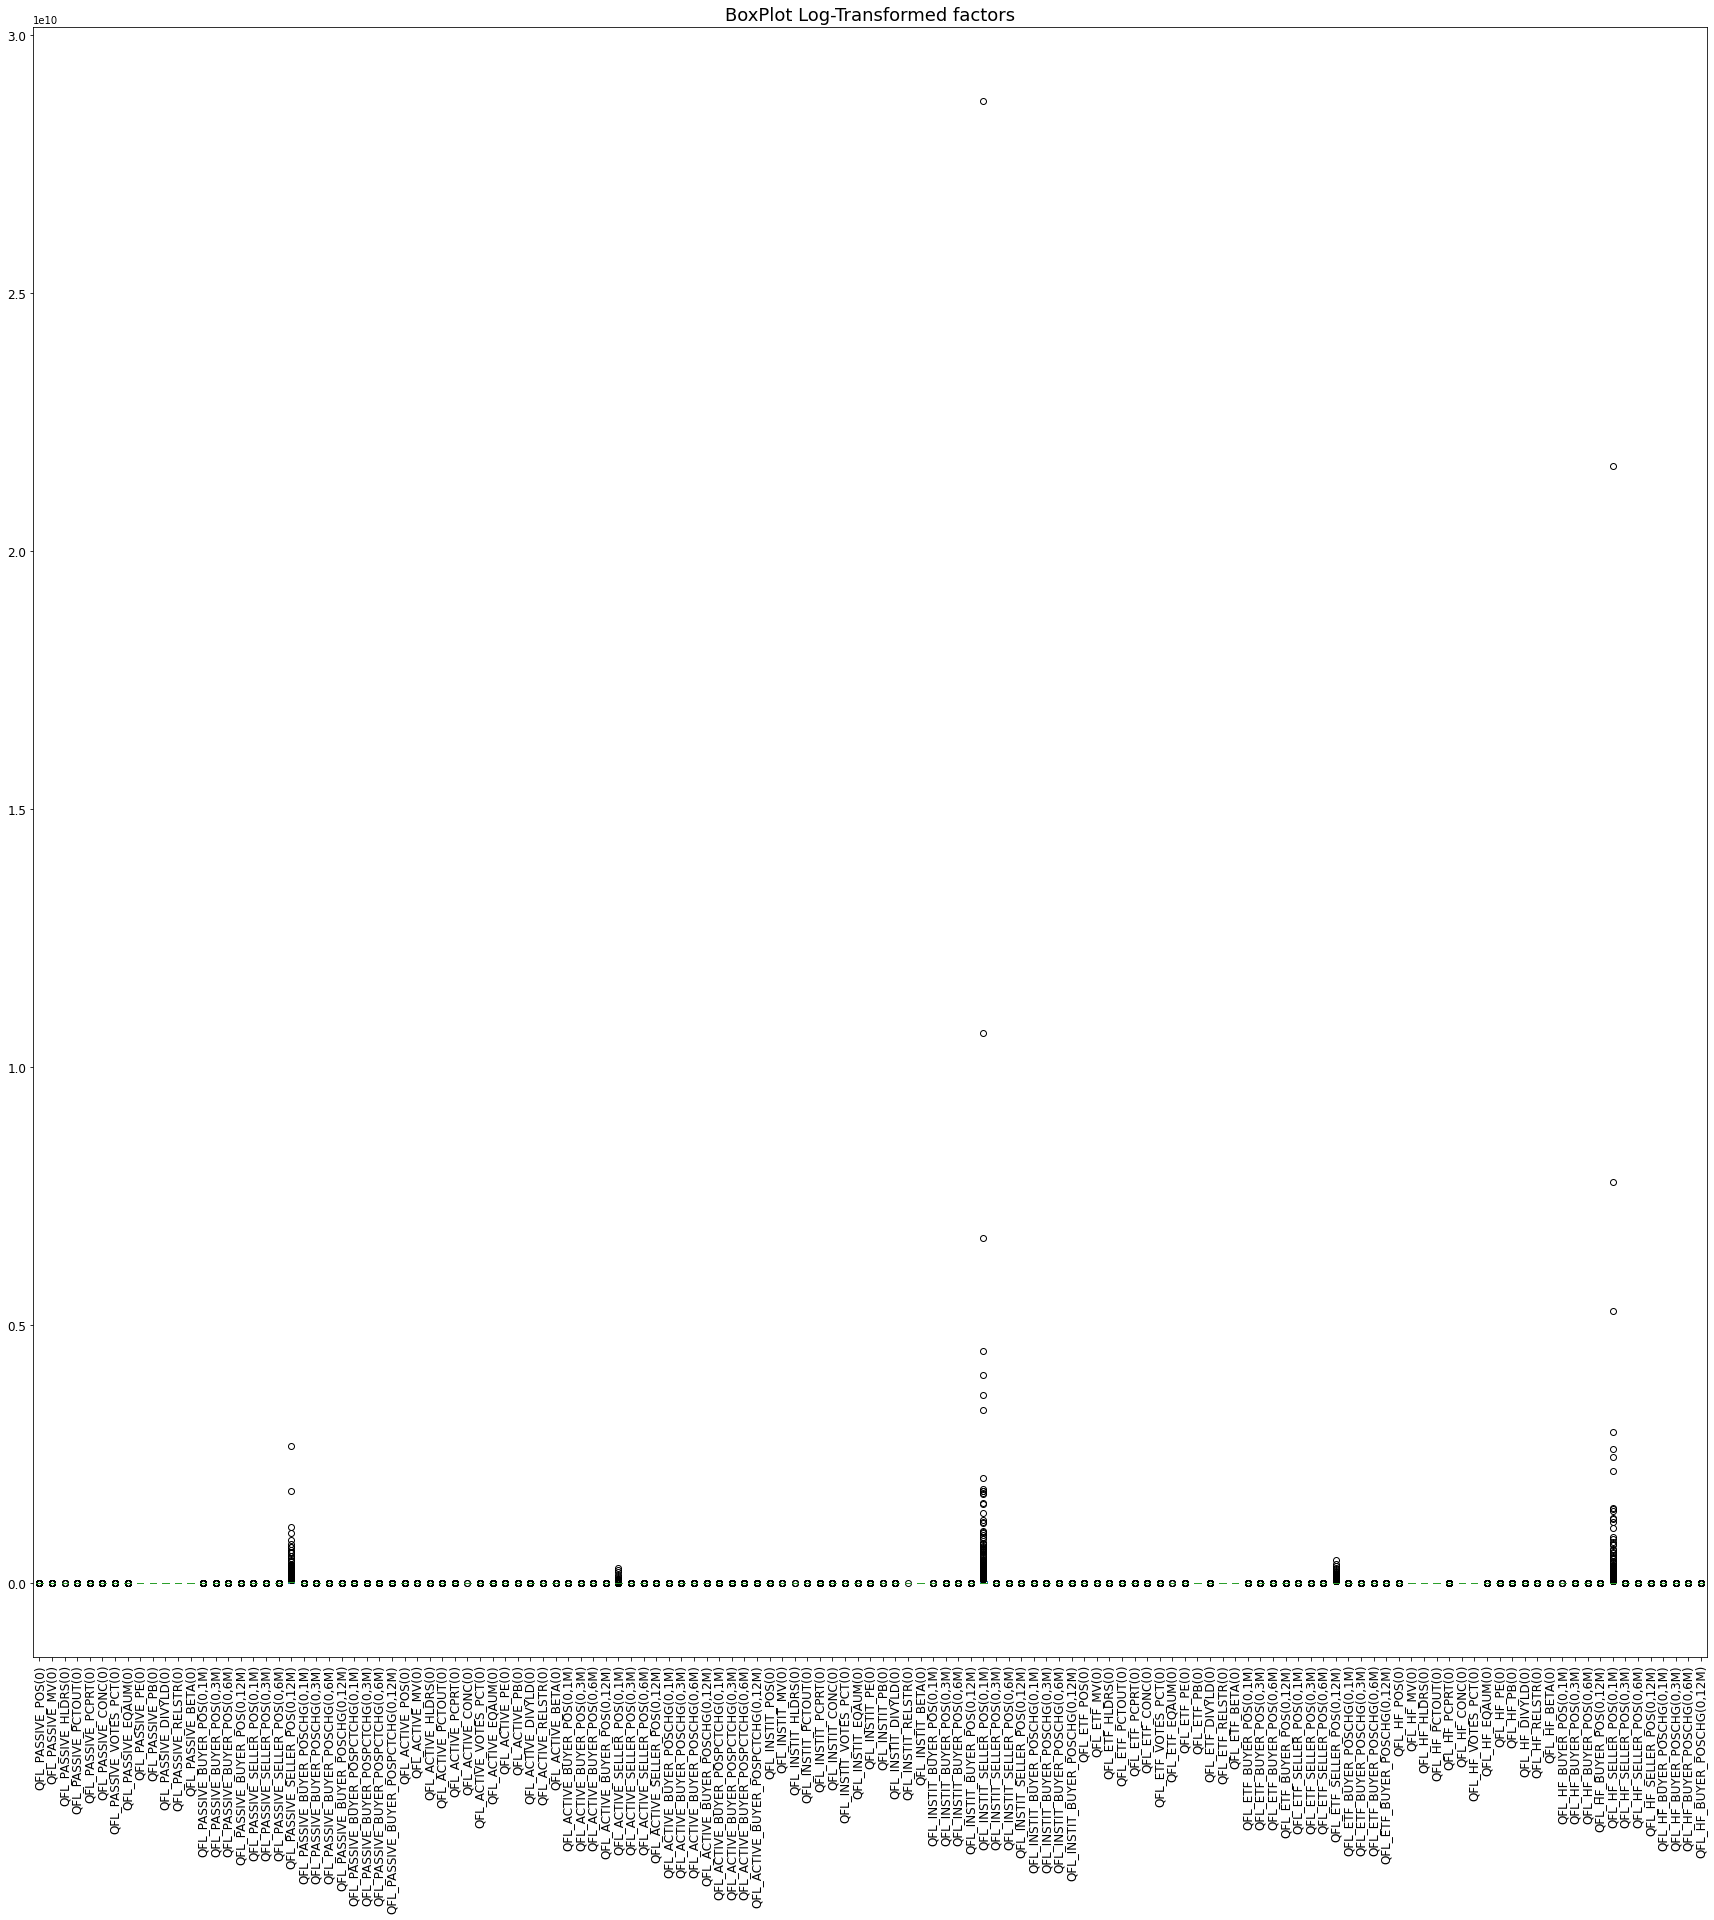

In [78]:
# Box-Whisker plot of Log-Transformed data

qfl_df_log.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log-Transformed factors', fontsize = 18);

In [79]:
# MFR Z-Score of Log-Transformed and Z-Scored data

# Z-Score of Log-Transformed data

qfl_df_log_z = pd.DataFrame()

for factor in qfl_df_log:
    z_score = ( qfl_df_log[factor] - qfl_df_log[factor].mean() ) / qfl_df_log[factor].std()
    qfl_df_log_z[factor] = z_score

qfl_df_log_z['MFR'] = qfl_df_log_z.mean(axis = 1)

qfl_df_log_z.head()

,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_BUYER_POSCHG(0,1M)","QFL_ETF_BUYER_POSCHG(0,3M)","QFL_ETF_BUYER_POSCHG(0,6M)","QFL_ETF_BUYER_POSCHG(0,12M)",QFL_HF_POS(0),QFL_HF_MV(0),QFL_HF_HLDRS(0),QFL_HF_PCTOUT(0),QFL_HF_PCPRT(0),QFL_HF_CONC(0),QFL_HF_VOTES_PCT(0),QFL_HF_EQAUM(0),QFL_HF_PE(0),QFL_HF_PB(0),QFL_HF_DIVYLD(0),QFL_HF_RELSTR(0),QFL_HF_BETA(0),"QFL_HF_BUYER_POS(0,1M)","QFL_HF_BUYER_POS(0,3M)","QFL_HF_BUYER_POS(0,6M)","QFL_HF_BUYER_POS(0,12M)","QFL_HF_SELLER_POS(0,1M)","QFL_HF_SELLER_POS(0,3M)","QFL_HF_SELLER_POS(0,6M)","QFL_HF_SELLER_POS(0,12M)","QFL_HF_BUYER_POSCHG(0,1M)","QFL_HF_BUYER_POSCHG(0,3M)","QFL_HF_BUYER_POSCHG(0,6M)","QFL_HF_BUYER_POSCHG(0,12M)",MFR
0,3.008017,4.146174,2.247669,0.534575,4.381441,0.48491,0.494374,1.471291,1.400482,1.784562,-1.598543,1.236006,1.337851,2.846543,2.411476,2.346954,2.570007,3.027518,3.254536,3.118458,15.629663,2.048980,1.602940,1.731478,2.244972,-11.548381,-4.023554,20.374395,20.995031,2.455176,3.210524,3.102240,-0.558625,11.181009,-1.805042,-0.540893,0.513045,1.162442,1.795976,-1.065731,1.199653,1.456048,1.963486,2.022569,2.208957,2.161849,5.618871,2.623473,2.572198,2.680584,1.163235,1.633267,1.787814,2.031469,-1.339072,-0.066157,8.151962,10.407236,2.958070,3.752106,3.067120,0.393991,19.202754,-0.234145,0.371878,1.123154,0.271268,1.644376,-0.640353,1.217591,1.368216,0.774275,1.977574,2.310015,2.289289,-0.064215,3.109400,3.240065,3.273080,1.364560,1.840672,1.705

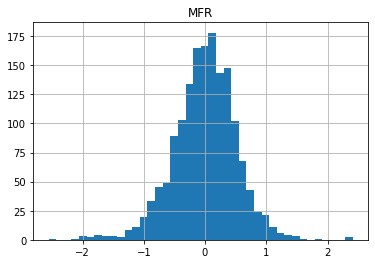

In [80]:
# MFR Distribution (of Log-Transformed and Z-Score factors)

pd.DataFrame(qfl_df_log_z['MFR']).hist(bins = int(np.sqrt(len(qfl_df_log_z['MFR']))));

In [81]:
# Check Infomation Coefficient: MRF (Components: All, Z-Scored & Log-Transformed)

sp_corr_z_log, sp_pval_z_log = stats.spearmanr(-qfl_df_log_z['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.08
Information Coefficient (P-Value): 0.0


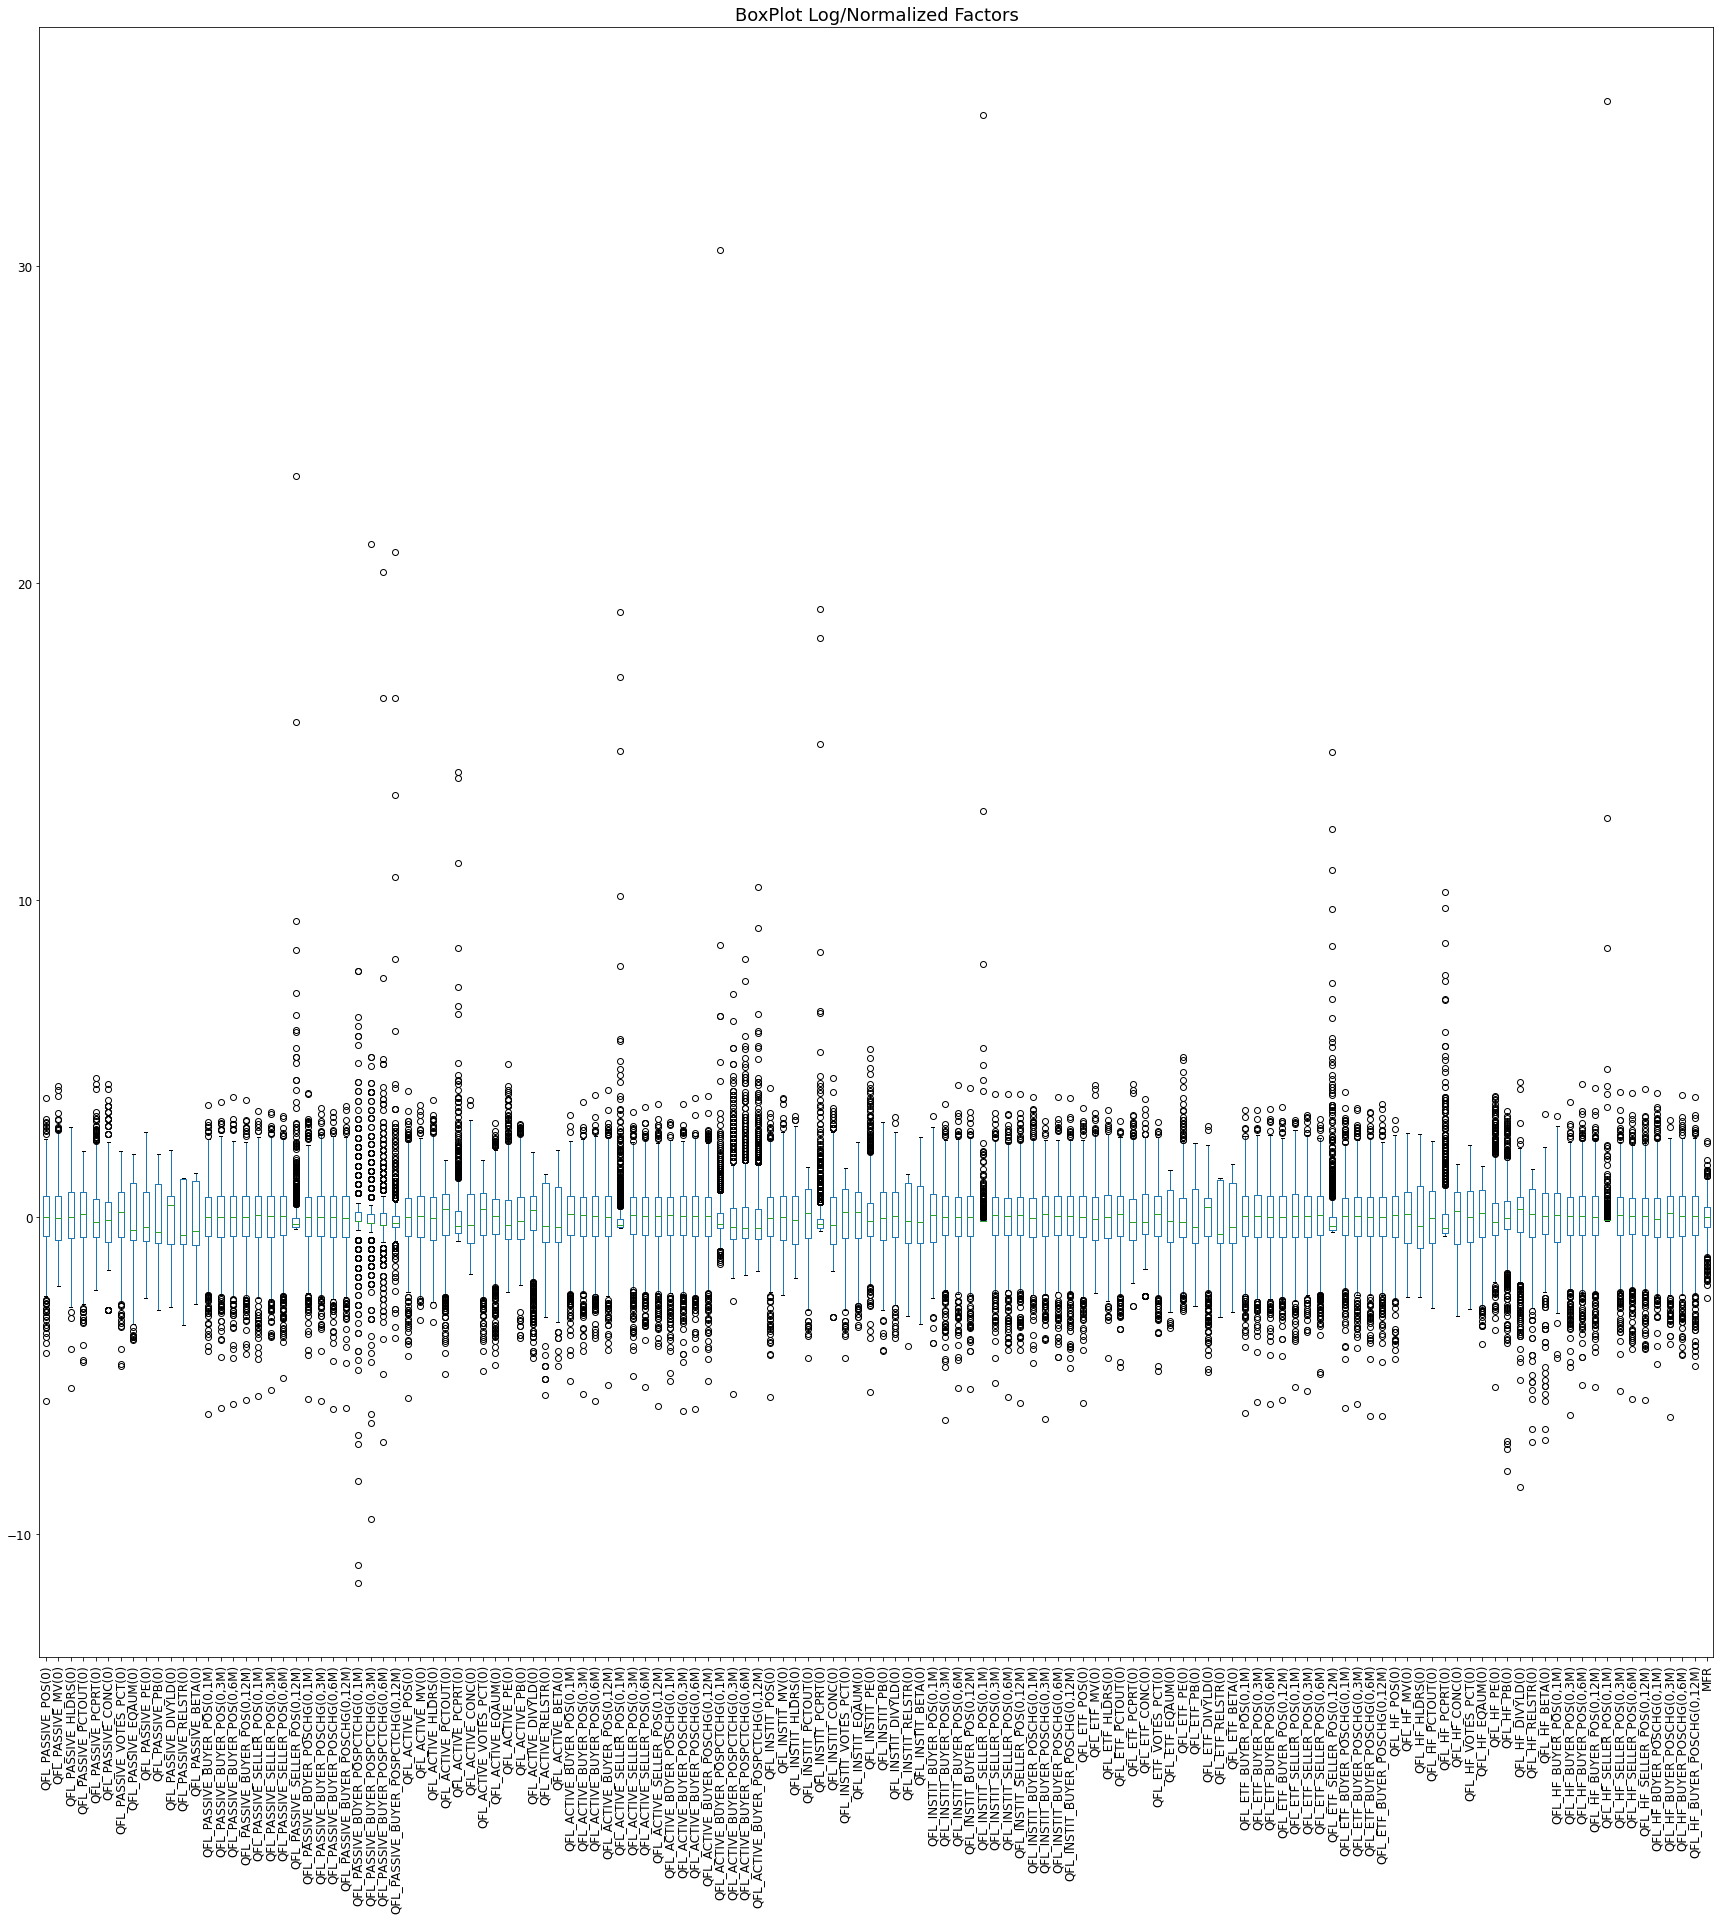

In [82]:
# Box-Whisker plot of Log-Transformed and Z-Score data

qfl_df_log_z.boxplot(grid=False, rot=90, fontsize=12, figsize = (30,30)).set_title('BoxPlot Log/Normalized Factors', fontsize = 18);

In [83]:
# Check Universe Exposures (Geography, Size, Sector)

qfl_df['ison_screen'] = 1

qfl_df.head()

,BENCHMARK_ID,DATE,SECURITY_ID,Weight,proper_name,fg_gics_sector,proper,p_total_return,qfl_size_class,qfl_mkt_val_sec,QFL_PASSIVE_POS(0),QFL_PASSIVE_MV(0),QFL_PASSIVE_HLDRS(0),QFL_PASSIVE_PCTOUT(0),QFL_PASSIVE_PCPRT(0),QFL_PASSIVE_CONC(0),QFL_PASSIVE_VOTES_PCT(0),QFL_PASSIVE_EQAUM(0),QFL_PASSIVE_PE(0),QFL_PASSIVE_PB(0),QFL_PASSIVE_DIVYLD(0),QFL_PASSIVE_RELSTR(0),QFL_PASSIVE_BETA(0),"QFL_PASSIVE_DTL(0,21D)","QFL_PASSIVE_DTL(0,63D)","QFL_PASSIVE_DTL(0,252D)","QFL_PASSIVE_BUYER_POS(0,1M)","QFL_PASSIVE_BUYER_POS(0,3M)","QFL_PASSIVE_BUYER_POS(0,6M)","QFL_PASSIVE_BUYER_POS(0,12M)","QFL_PASSIVE_SELLER_POS(0,1M)","QFL_PASSIVE_SELLER_POS(0,3M)","QFL_PASSIVE_SELLER_POS(0,6M)","QFL_PASSIVE_SELLER_POS(0,12M)","QFL_PASSIVE_BUYER_POSCHG(0,1M)","QFL_PASSIVE_BUYER_POSCHG(0,3M)","QFL_PASSIVE_BUYER_POSCHG(0,6M)","QFL_PASSIVE_BUYER_POSCHG(0,12M)","QFL_PASSIVE_SELLER_POSCHG(0,1M)","QFL_PASSIVE_SELLER_POSCHG(0,3M)","QFL_PASSIVE_SELLER_POSCHG(0,6M)","QFL_PASSIVE_SELLER_POSCHG(0,12M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,1M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,3M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,6M)","QFL_PASSIVE_BUYER_POSPCTCHG(0,12M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,1M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,3M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,6M)","QFL_PASSIVE_SELLER_POSPCTCHG(0,12M)",QFL_ACTIVE_POS(0),QFL_ACTIVE_MV(0),QFL_ACTIVE_HLDRS(0),QFL_ACTIVE_PCTOUT(0),QFL_ACTIVE_PCPRT(0),QFL_ACTIVE_CONC(0),QFL_ACTIVE_VOTES_PCT(0),QFL_ACTIVE_EQAUM(0),QFL_ACTIVE_PE(0),QFL_ACTIVE_PB(0),QFL_ACTIVE_DIVYLD(0),QFL_ACTIVE_RELSTR(0),QFL_ACTIVE_BETA(0),"QFL_ACTIVE_DTL(0,21D)","QFL_ACTIVE_DTL(0,63D)","QFL_ACTIVE_DTL(0,252D)","QFL_ACTIVE_BUYER_POS(0,1M)","QFL_ACTIVE_BUYER_POS(0,3M)","QFL_ACTIVE_BUYER_POS(0,6M)","QFL_ACTIVE_BUYER_POS(0,12M)","QFL_ACTIVE_SELLER_POS(0,1M)","QFL_ACTIVE_SELLER_POS(0,3M)","QFL_ACTIVE_SELLER_POS(0,6M)","QFL_ACTIVE_SELLER_POS(0,12M)","QFL_ACTIVE_BUYER_POSCHG(0,1M)","QFL_ACTIVE_BUYER_POSCHG(0,3M)","QFL_ACTIVE_BUYER_POSCHG(0,6M)","QFL_ACTIVE_BUYER_POSCHG(0,12M)","QFL_ACTIVE_SELLER_POSCHG(0,1M)","QFL_ACTIVE_SELLER_POSCHG(0,3M)","QFL_ACTIVE_SELLER_POSCHG(0,6M)","QFL_ACTIVE_SELLER_POSCHG(0,12M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,1M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,3M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,6M)","QFL_ACTIVE_BUYER_POSPCTCHG(0,12M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,1M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,3M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,6M)","QFL_ACTIVE_SELLER_POSPCTCHG(0,12M)",QFL_INSTIT_POS(0),QFL_INSTIT_MV(0),QFL_INSTIT_HLDRS(0),QFL_INSTIT_PCTOUT(0),QFL_INSTIT_PCPRT(0),QFL_INSTIT_CONC(0),QFL_INSTIT_VOTES_PCT(0),QFL_INSTIT_EQAUM(0),QFL_INSTIT_PE(0),QFL_INSTIT_PB(0),QFL_INSTIT_DIVYLD(0),QFL_INSTIT_RELSTR(0),QFL_INSTIT_BETA(0),"QFL_INSTIT_DTL(0,21D)","QFL_INSTIT_DTL(0,63D)","QFL_INSTIT_DTL(0,252D)","QFL_INSTIT_BUYER_POS(0,1M)","QFL_INSTIT_BUYER_POS(0,3M)","QFL_INSTIT_BUYER_POS(0,6M)","QFL_INSTIT_BUYER_POS(0,12M)","QFL_INSTIT_SELLER_POS(0,1M)","QFL_INSTIT_SELLER_POS(0,3M)","QFL_INSTIT_SELLER_POS(0,6M)","QFL_INSTIT_SELLER_POS(0,12M)","QFL_INSTIT_BUYER_POSCHG(0,1M)","QFL_INSTIT_BUYER_POSCHG(0,3M)","QFL_INSTIT_BUYER_POSCHG(0,6M)","QFL_INSTIT_BUYER_POSCHG(0,12M)","QFL_INSTIT_SELLER_POSCHG(0,1M)","QFL_INSTIT_SELLER_POSCHG(0,3M)","QFL_INSTIT_SELLER_POSCHG(0,6M)","QFL_INSTIT_SELLER_POSCHG(0,12M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,1M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,3M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,6M)","QFL_INSTIT_BUYER_PCTPOSCHG(0,12M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,1M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,3M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,6M)","QFL_INSTIT_SELLER_PCTPOSCHG(0,12M)",QFL_ETF_POS(0),QFL_ETF_MV(0),QFL_ETF_HLDRS(0),QFL_ETF_PCTOUT(0),QFL_ETF_PCPRT(0),QFL_ETF_CONC(0),QFL_ETF_VOTES_PCT(0),QFL_ETF_EQAUM(0),QFL_ETF_PE(0),QFL_ETF_PB(0),QFL_ETF_DIVYLD(0),QFL_ETF_RELSTR(0),QFL_ETF_BETA(0),"QFL_ETF_DTL(0,21D)","QFL_ETF_DTL(0,63D)","QFL_ETF_DTL(0,252D)","QFL_ETF_BUYER_POS(0,1M)","QFL_ETF_BUYER_POS(0,3M)","QFL_ETF_BUYER_POS(0,6M)","QFL_ETF_BUYER_POS(0,12M)","QFL_ETF_SELLER_POS(0,1M)","QFL_ETF_SELLER_POS(0,3M)","QFL_ETF_SELLER_POS(0,6M)","QFL_ETF_SELLER_POS(0,12M)","QFL_ETF_B

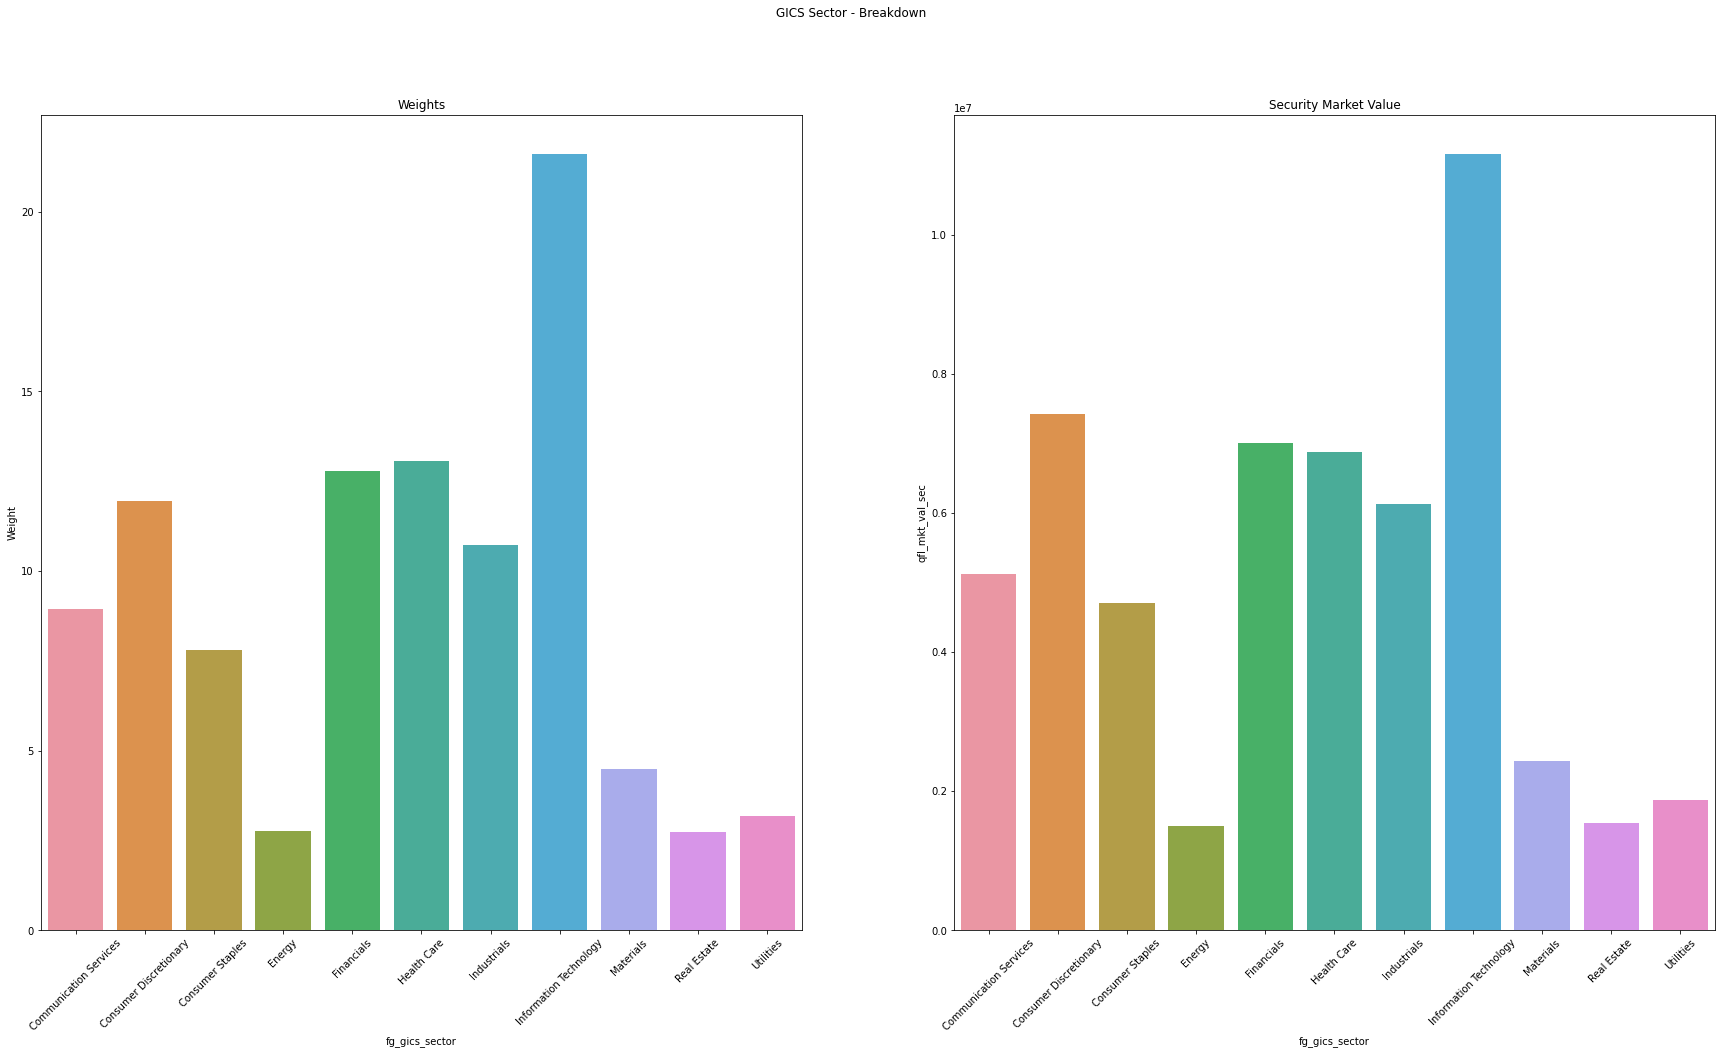

In [84]:
# Group universe

# GICS Sector
GICS_grouped = qfl_df.groupby('fg_gics_sector').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('GICS Sector - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('Security Market Value')

chart = sns.barplot(ax=axes[0], x = GICS_grouped.index, y = 'Weight', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = GICS_grouped.index, y = 'qfl_mkt_val_sec', data = GICS_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

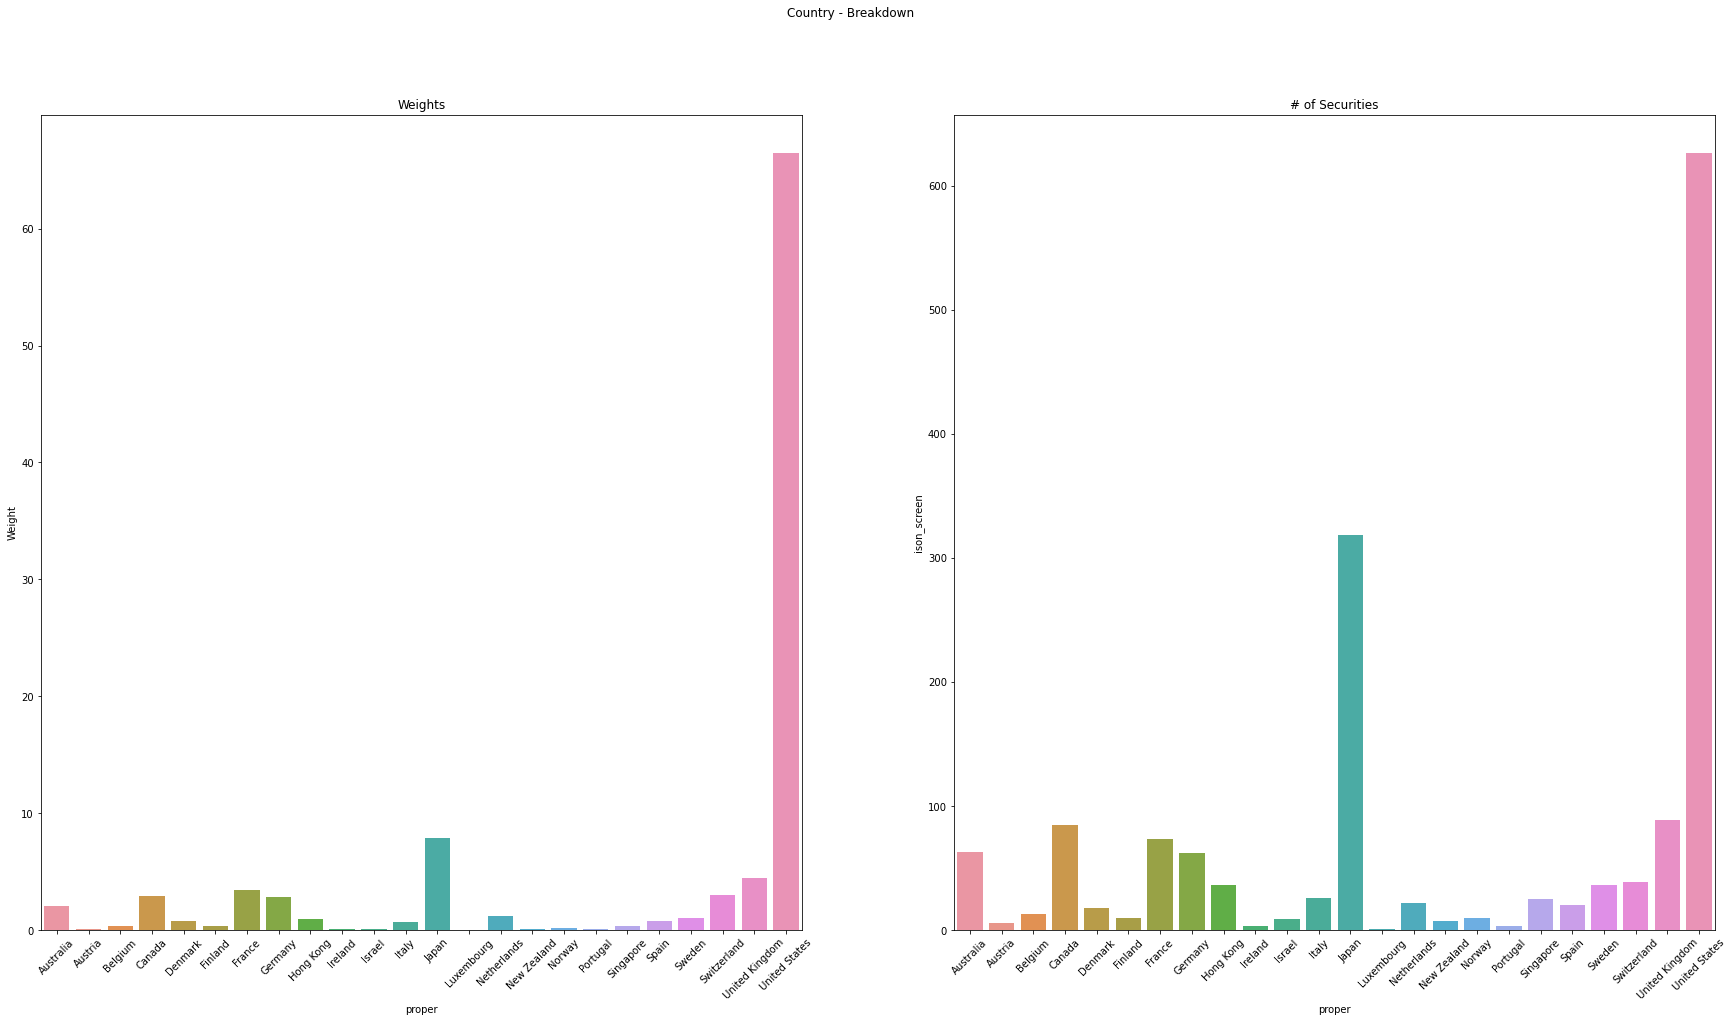

In [85]:
# Group universe

# Country
Country_grouped = qfl_df.groupby('proper').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Country_grouped.index, y = 'Weight', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Country_grouped.index, y = 'ison_screen', data = Country_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

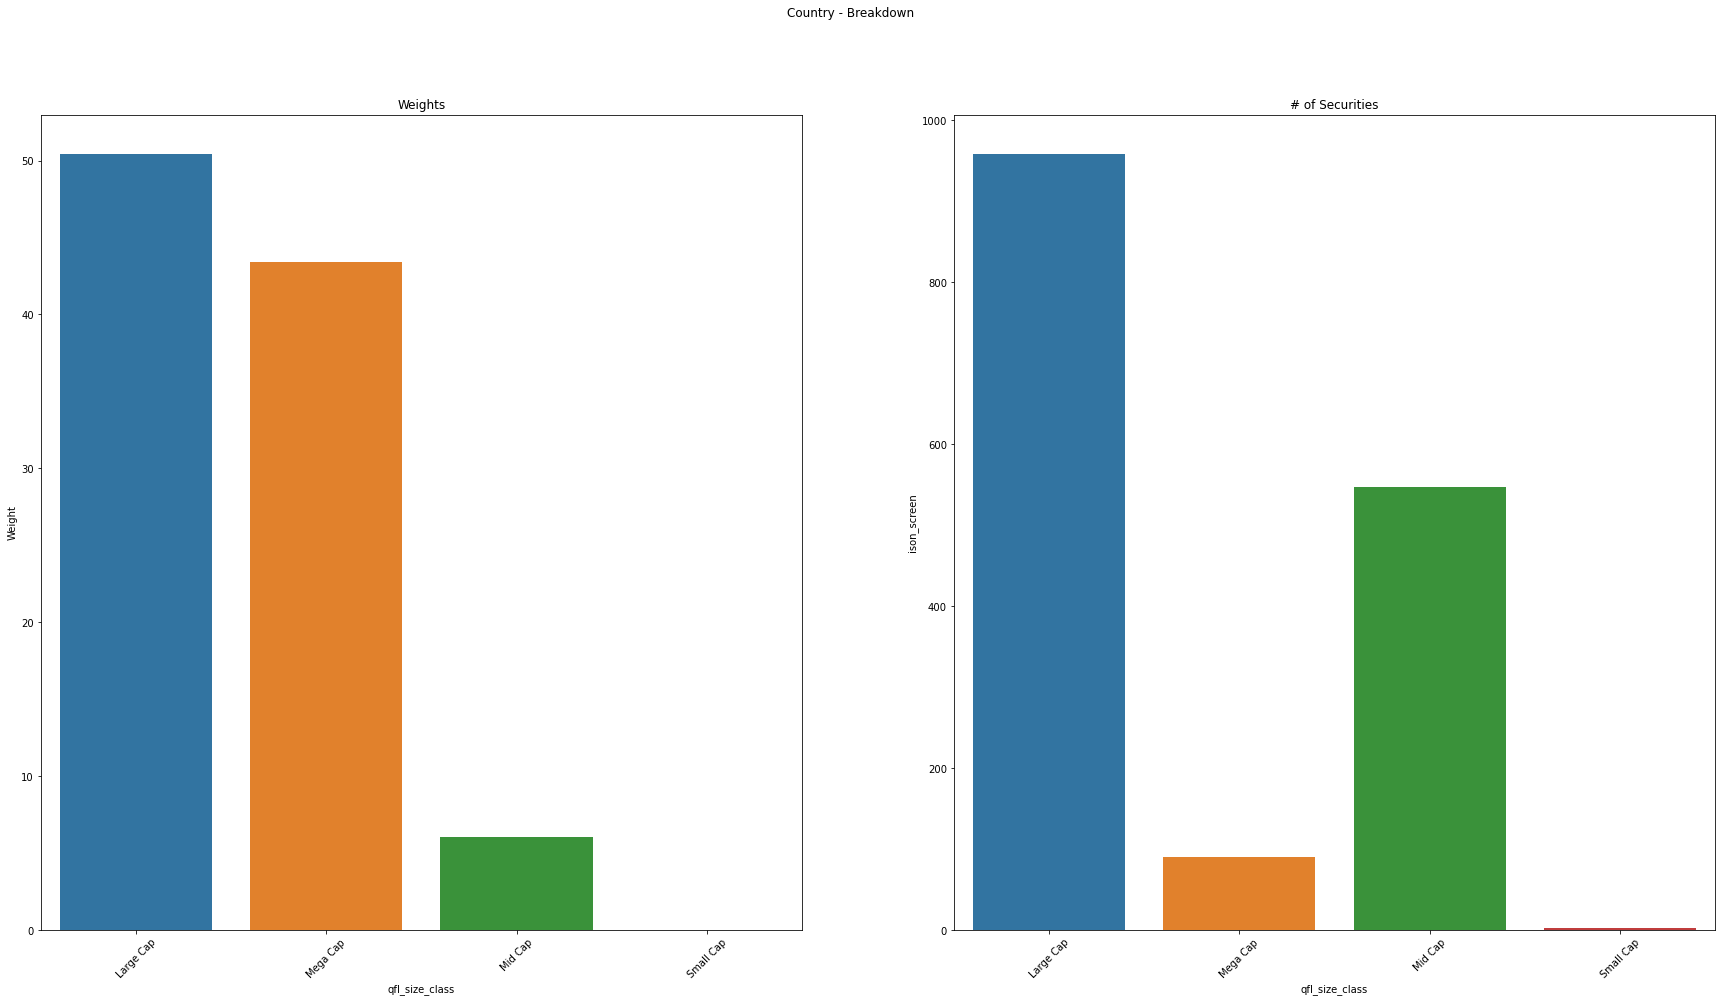

In [86]:
# Group universe

# Size
Size_grouped = qfl_df.groupby('qfl_size_class').sum()

fig, axes = plt.subplots(1, 2, figsize=(30, 15))
fig.suptitle('Country - Breakdown')
axes[0].set_title('Weights')
axes[1].set_title('# of Securities')

chart = sns.barplot(ax=axes[0], x = Size_grouped.index, y = 'Weight', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
chart = sns.barplot(ax=axes[1], x = Size_grouped.index, y = 'ison_screen', data = Size_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45);

In [ ]:
# Feature Selection

In [87]:
# Discard features with more than 80 NAs

qfl_filtered = qfl_df[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0)[qfl_df[qfl_df.columns[filter_idx]].isna().sum(axis = 0) < 80].index]

In [104]:
# Replace NAs for retained features with feature's average

for col in qfl_filtered.columns:
    qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))
    
qfl_df['p_total_return'] = qfl_df['p_total_return'].replace(np.nan, 0);

<ipython-input-104-d861f91d7765>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qfl_filtered[col] = qfl_filtered[col].replace(np.nan, qfl_filtered[col].mean(axis = 0))


In [89]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

X = qfl_filtered
Y = qfl_df['p_total_return']

#RECURSIVE FEATURE ELIMINATION

lin_reg = Lasso()
rfe = RFE(lin_reg, n_features_to_select=3, step = 1)
fit_rfe = rfe.fit(X, Y)
print("Num Features: %s" % (fit_rfe.n_features_))
print("Selected Features: %s" % (fit_rfe.support_))
print("Feature Ranking: %s" % (fit_rfe.ranking_))


C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38462.0868088109, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38462.0868088109, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38462.0868088109, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38462.206992802465, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38462.206992802465, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38462.206992802465, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWar

C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38839.45470089618, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38838.41095216897, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38837.463136642524, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarni

C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39003.50602169594, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39068.96329022276, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39169.77794726384, tolerance: 8.407531333952104
  model = cd_fast.enet_coordinate_descent(
C:\Users\ffais\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarnin

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False]
Feature Ranking: [ 42  78   4  87  86  85  80  84  83  90  91  99  25  27  45  33  55  29
  69  31   7  10  12  14 100 102 104 107  59  79   6 115 117 119  81 122
 124 110 111 109  37  

In [96]:
qfl_filtered.columns[fit_rfe.support_]

Index(['QFL_INSTIT_PCTOUT(0)', 'QFL_ETF_PE(0)', 'QFL_HF_PCTOUT(0)'], dtype='object')

In [97]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]].corr()

,QFL_INSTIT_PCTOUT(0),QFL_ETF_PE(0),QFL_HF_PCTOUT(0)
QFL_INSTIT_PCTOUT(0),1.000000,0.55544,0.522658
QFL_ETF_PE(0),0.555440,1.00000,0.448100
QFL_HF_PCTOUT(0),0.522658,0.44810,1.000000


In [ ]:
qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]

In [98]:
# MFR Z-Score after Feature Selection

qfl_mfr_RFE = pd.DataFrame()

for factor in qfl_filtered[qfl_filtered.columns[fit_rfe.support_]]:
    z_score_RFE = ( qfl_filtered[factor] - qfl_filtered[factor].mean() ) / qfl_filtered[factor].std()
    qfl_mfr_RFE[factor] = z_score_RFE

qfl_mfr_RFE['MFR'] = qfl_mfr_RFE.mean(axis = 1)

qfl_mfr_RFE.head()

,QFL_INSTIT_PCTOUT(0),QFL_ETF_PE(0),QFL_HF_PCTOUT(0),MFR
0,0.152299,1.428757,-0.472246,0.369603
1,0.622146,1.409508,-0.138510,0.631048
2,0.161703,1.640495,-0.160181,0.547339
3,0.891377,1.345838,0.310084,0.849100
4,0.504423,1.351761,-0.001981,0.618068


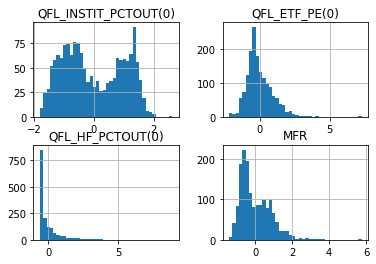

In [99]:
qfl_mfr_RFE.hist(bins = int(np.sqrt(len(qfl_mfr_RFE['MFR']))));

In [100]:
# Check Infomation Coefficient: MFR (Components: RFE's Feature Selected, Z-Scored)

sp_corr_z_rfe, sp_pval_z_rfe = stats.spearmanr(-qfl_mfr_RFE['MFR'].replace(np.nan, 0), qfl_df['p_total_return'].replace(np.nan, 0))
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.23
Information Coefficient (P-Value): 0.0


# Information Coefficient Summary (LVRB)

### Feature Selection: Recoursive Feature Elimination (RFE + Lasso) (3 Top Components)

In [101]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_rfe,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_rfe,2)))

Information Coefficient: -0.23
Information Coefficient (P-Value): 0.0


### Z-Score + Log-Transformation (All Components)

In [102]:
print('Information Coefficient: {0}'.format(round(sp_corr_z_log,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z_log,2)))

Information Coefficient: -0.08
Information Coefficient (P-Value): 0.0


### Z-Score Only (All Components)

In [103]:
print('Information Coefficient: {0}'.format(round(sp_corr_z,2)))
print('Information Coefficient (P-Value): {0}'.format(round(sp_pval_z,2)))

Information Coefficient: 0.05
Information Coefficient (P-Value): 0.04
